# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import string

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

from scipy import stats

import suppression as s
import utils

In [4]:
pd.__version__

'0.24.2'

In [5]:
sns.__version__

'0.9.0'

In [6]:
sns

<module 'seaborn' from '//anaconda/envs/py36/lib/python3.6/site-packages/seaborn/__init__.py'>

In [7]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [8]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [9]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])

In [10]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)
demos

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


In [11]:
demos[demos.initials=='nl']

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
22,34,nl,NL_060814,33,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.21,0.218


### Set variables used for graphing

In [12]:
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
plot_dir = f"plots/redo-202001-{gaba_col}-fixeyes"

## Analyze tasks separately (before subsetting to include common subjects)##

In [13]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [14]:
gdf

,subjName,Population,Presentation,GABA
2,ac,Persons with Amblyopia,mean_occ_all,0.198
6,am,Persons with Amblyopia,mean_occ_all,0.194
10,as,Persons with Amblyopia,mean_occ_all,0.217
14,bi,Persons with Amblyopia,mean_occ_all,0.205
18,ch,Persons with Amblyopia,mean_occ_all,0.184
22,cs,Persons with Amblyopia,mean_occ_all,0.220
26,em,Persons with Amblyopia,mean_occ_all,0.185
30,gd,Persons with Amblyopia,mean_occ_all,0.197
34,jv,Persons with Amblyopia,mean_occ_all,0.201
38,ks,Persons with Amblyopia,mean_occ_all,0.207


#### Remove AM and TT based on discussions with Kelly 12/2019.

In [15]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
pop_group_reduced.describe()

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

In [16]:
#print(*pop_group_reduced['GABA'])
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760943 0.48047050303580596


In [17]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                         count      mean       std    min     50%    max
Population                                                              
Persons with Amblyopia    16.0  0.199813  0.015276  0.162  0.2005  0.220
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.2030  0.223

In [18]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.30189405829905 0.20319932494233123


**Thus we find no significant difference in GABA levels between CON and AMB regardless of whether AM and TT are included. At this point we may as well proceed with gdf_reduced only.**

### GABA violin plot, all subjects

In [19]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

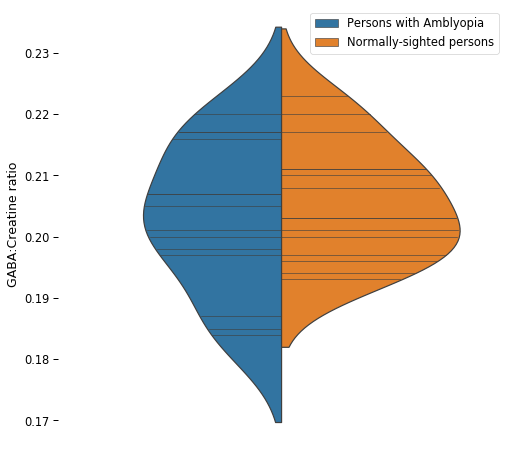

In [20]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}_{gaba_col}.pdf") as pdf:
    #with sns.plotting_context(context=None, font_scale=1.3):
    sns.set_context(context="paper", font_scale=1.3)
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,inner='stick',ax=ax,legend=False)
    ax.legend()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    sns.despine(left=True, bottom=True, right=True)
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [21]:
task = 'SS' # 'SS'
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy() # make a deep copy

In [22]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [23]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Verifying baselines based on KB feedback about fig R2

In [24]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]

In [25]:
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()

In [26]:
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()

In [27]:
np.setdiff1d(cnde_subs, cde_subs)

array(['ap', 'bo', 'gw', 'ke', 'nn', 'tj'], dtype=object)

In [28]:
onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace'])['BaselineThresh'].describe()

count      mean  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De    53.0  6.201226   
                                         Nde Amblyope-Nde   54.0  7.201574   
                              Control    De  Control-De     54.0  6.306926   
                                         Nde Control-Nde    85.0  5.879106   

                                                                std    min  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De   1.216117  4.063   
                                         Nde Amblyope-Nde  2.227975  4.558   
                              Control    De  Control-De    1.449616  4.033   
                                         Nde Control-Nde   1.339842  3.124   

                                                             25%    50%  \
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   5.949  6.262   
                                         Nde Amblyope-Nde  5.944  6.787   
                              Control    De  Control-De    5.478  6.458   
                                         Nde Control-Nde   5.006  5.741   

                                                             75%     max  
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   6.826   7.827  
                                         Nde Amblyope-Nde  7.834  13.226  
                              Control    De  Control-De    6.892   9.987  
                                         Nde Control-Nde   6.405   8.794

In [29]:
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace',"Subject"])['BaselineThresh'].mean().reset_index()

In [30]:
thresh_noswap.head()

,Task,Orientation,Presentation,Population,Eye,Trace,Subject,BaselineThresh
0,SS,Iso,nMono,Amblyope,De,Amblyope-De,ah,7.590
1,SS,Iso,nMono,Amblyope,De,Amblyope-De,am,7.532
2,SS,Iso,nMono,Amblyope,De,Amblyope-De,bi,7.827
3,SS,Iso,nMono,Amblyope,De,Amblyope-De,cl,6.709
4,SS,Iso,nMono,Amblyope,De,Amblyope-De,eg,6.826


In [31]:
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()

In [32]:
eye_counts

,index,Subject
0,se,2
1,ei,2
2,rn,2
3,kw,2
4,ls,2
5,am,2
6,gm,2
7,eg,2
8,li,2
9,mk,2


In [33]:
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()

In [34]:
nounpaired

array(['se', 'ei', 'rn', 'kw', 'ls', 'am', 'gm', 'eg', 'li', 'mk', 'gd',
       'nl', 'ai', 'mg', 'ah', 'es', 'ms', 'jd', 'ct', 'cl', 'dl', 'cr',
       'bi', 'yl', 'mv', 'em', 'tm', 'jv', 'sd'], dtype=object)

In [35]:
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]

In [36]:
thresh_noswap.groupby(['Trace']).mean().reset_index()

,Trace,BaselineThresh
0,Amblyope-De,6.136462
1,Amblyope-Nde,7.318385
2,Control-De,6.309750
3,Control-Nde,5.894955


In [37]:
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

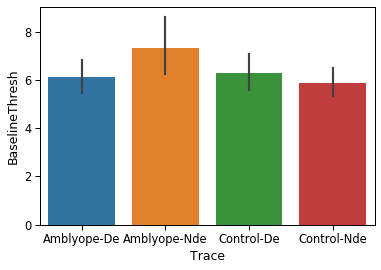

In [38]:
sns.barplot(data=thresh_noswap, x="Trace", y="BaselineThresh")

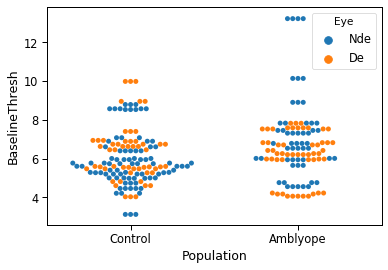

In [39]:
sns.swarmplot(data=onecond, x="Population", y="BaselineThresh", hue="Eye")

### This is where the NDE/DE should be switched based on KB findings (only affects Controls, luckily)

But as the above plot shows, there are many more in Control-Nde than Control-De

In [40]:
def swap_eyevars(df, subs=subs_to_swap_eyes):
    #print(df, df['Subject'], len(df), sep='\n')
    if df['Subject'] in subs: # fix here
        print(df['Subject'], "SWAP!")
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    print(rows_to_change[disp_cols])
    assert(np.all(rows_to_change.Population == 'Control')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, axis=1)
    print(fixed[disp_cols])
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

    Subject  Eye        Trace  BaselineThresh
0        ai  Nde  Control-Nde           6.900
1        ai  Nde  Control-Nde           6.900
2        ai  Nde  Control-Nde           6.900
17       ct  Nde  Control-Nde           8.794
18       ct  Nde  Control-Nde           8.794
19       ct  Nde  Control-Nde           8.794
20       dl  Nde  Control-Nde           5.772
21       dl  Nde  Control-Nde           5.772
22       dl  Nde  Control-Nde           5.772
23       dl  Nde  Control-Nde           5.772
24       dl  Nde  Control-Nde           5.772
25       ei  Nde  Control-Nde           4.985
26       ei  Nde  Control-Nde           4.985
27       ei  Nde  Control-Nde           4.985
51       kw  Nde  Control-Nde           5.292
52       kw  Nde  Control-Nde           5.292
53       kw  Nde  Control-Nde           5.292
63       nl  Nde  Control-Nde           5.276
64       nl  Nde  Control-Nde           5.276
65       nl  Nde  Control-Nde           5.276
139      ai   De   Control-De     

### Toggle which version of the data to use, "fixed" eyes or not

In [41]:
df_to_model = df_to_model_fixeyes

### GABA vs baseline contrast threshold, before excluding bad fits

In [42]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [43]:
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()

In [44]:
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,NaN,7.590,BaselineThresh
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,NaN,4.558,BaselineThresh
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,NaN,7.532,BaselineThresh
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,NaN,7.834,BaselineThresh
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.205,7.827,BaselineThresh


In [45]:
len(simple_bg_df.Subject.unique())

35

In [46]:
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [47]:
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe()

count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh   13.0  6.136462   
                                         Nde BaselineThresh   13.0  7.318385   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                 nMono        Amblyope   De  BaselineThresh   13.0  6.136462   
                                         Nde BaselineThresh   13.0  7.318385   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
     Iso         nDicho       Amblyope   De  BaselineThresh   13.0  6.136462   
                                         Nde BaselineThresh   13.0  7.318385   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   
                 nMono        Amblyope   De  BaselineThresh   13.0  6.136462   
                                         Nde BaselineThresh   13.0  7.318385   
                              Control    De  BaselineThresh   16.0  6.153313   
                                         Nde BaselineThresh   22.0  6.008727   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh  1.280663  4.063   
                                         Nde BaselineThresh  2.364243  4.558   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                 nMono        Amblyope   De  BaselineThresh  1.280663  4.063   
                                         Nde BaselineThresh  2.364243  4.558   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
     Iso         nDicho       Amblyope   De  BaselineThresh  1.280663  4.063   
                                         Nde BaselineThresh  2.364243  4.558   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   
                 nMono        Amblyope   De  BaselineThresh  1.280663  4.063   
                                         Nde BaselineThresh  2.364243  4.558   
                              Control    De  BaselineThresh  1.557727  4.033   
                                         Nde BaselineThresh  1.452858  3.124   

                                                                 25%     50%  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       Amblyope   De  BaselineThresh  5.94900  6.2620   
                                         Nde BaselineThresh  5.94400  6.7870   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                 nMono        Amblyope   De  BaselineThresh  5.94900  6.2620   
                                         Nde BaselineThresh  5.94400  6.7870   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
     Iso         nDicho       Amblyope   De  BaselineThresh  5.94900  6.2620   
                                         Nde BaselineThresh  5.94400  6.7870   
                              Control    De  BaselineThresh  5.27500  5.5640   
                                         Nde BaselineThresh  5.05575  5.8465   
                 nMono        Amblyope   De  BaselineThresh

In [231]:
bg_groups = simple_bg_df.groupby(['Task','Orientation','Presentation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_{gaba_col}_baselines_noexc.pdf") as pdf:
    sns.set_context(context="paper", font_scale=1.3)
    for gv, gr in bg_groups:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr,
                    legend_box=[0.9, 0.60, 0.1, 0.15], log=True, ylim=(2.5, 15),
                    col="Population", hue="Trace",
                    sharex=False, sharey=False,
                    palette=colors4,
                    n_boot=5000, legend_img=False, markers=['o','s','o','s'])
        #g.fig.suptitle(f"{gv}", fontsize=10, y=0.999)
        g.set_titles("")
        g.fig.subplots_adjust(left=.08, wspace=.2, right=.85)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')


# Preparation for Modeling

In [49]:
df_to_model.head() # note the first rows, they will tell if fixed - ai/Nde/6.9 -> ai/De/6.9 

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,De,Control,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,De,Control,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,De,Control,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [50]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [51]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [52]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [53]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'Control', 'Nde', 'Control-Nde') 22


In [54]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
thresh_swap.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh
128,SS,Iso,nDicho,Amblyope,ah,De,Amblyope-De,7.590
129,SS,Iso,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558
130,SS,Iso,nDicho,Amblyope,am,De,Amblyope-De,7.532
131,SS,Iso,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827


In [55]:
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['se' 'ei' 'rn' 'kw' 'ls' 'am' 'gm' 'eg' 'li' 'mk' 'gd' 'nl' 'ai' 'mg'
 'ah' 'es' 'ms' 'jd' 'ct' 'cl' 'dl' 'cr' 'bi' 'yl' 'mv' 'em' 'tm' 'jv'
 'sd'] 29


In [56]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

In [57]:
pd.Series.value_counts(thresh_swap_nounpaired.Subject)

se    2
ah    2
rn    2
kw    2
ls    2
am    2
gm    2
eg    2
li    2
mk    2
gd    2
nl    2
ai    2
es    2
ei    2
mg    2
ms    2
bi    2
jv    2
tm    2
em    2
mv    2
jd    2
yl    2
cr    2
dl    2
cl    2
ct    2
sd    2
Name: Subject, dtype: int64

In [58]:
thresh_swap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                             \
                      count      mean       std    min      25%    50%   
Trace                                                                    
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.262   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.787   
Control-De             16.0  6.153313  1.557727  4.033  5.27500  5.564   
Control-Nde            16.0  6.078188  1.495439  3.124  5.25825  6.207   

                              
                 75%     max  
Trace                         
Amblyope-De   6.8260   7.827  
Amblyope-Nde  7.8340  13.226  
Control-De    6.8940   9.987  
Control-Nde   6.7945   8.957

#### Calculate differences, ratios etc for each subject

In [59]:
baseline_df_withinsubject = thresh_swap_nounpaired.groupby(['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_baseline_diff, 'BaselineThresh')
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="Amblyope") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,Amblyope,ah,De,Amblyope-De,7.590,-3.032,0.600527
130,SS,Iso,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.302,1.040096
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,2.314,1.295643
134,SS,Iso,nDicho,Amblyope,cl,De,Amblyope-De,6.709,0.749,1.111641
136,SS,Iso,nDicho,Amblyope,eg,De,Amblyope-De,6.826,-0.039,0.994287
138,SS,Iso,nDicho,Amblyope,em,De,Amblyope-De,5.949,0.065,1.010926
140,SS,Iso,nDicho,Amblyope,gd,De,Amblyope-De,6.210,0.326,1.052496
142,SS,Iso,nDicho,Amblyope,jv,De,Amblyope-De,4.227,0.537,1.127040
144,SS,Iso,nDicho,Amblyope,li,De,Amblyope-De,4.063,3.253,1.800640
146,SS,Iso,nDicho,Amblyope,mg,De,Amblyope-De,4.174,1.480,1.354576


In [60]:
ade_threshs = baseline_df_withinsubject[(baseline_df_withinsubject.Population=="Amblyope") & (baseline_df_withinsubject.Eye=="De")]

In [61]:
baseline_df_reduced = baseline_df_withinsubject.groupby(pp_gvars_base_agg).apply(utils.describe_baselines).reset_index()

In [62]:
baseline_df_reduced.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
0,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.136462,1.230422,0.341258
1,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.318385,2.271492,0.629998
2,SS,Iso,nDicho,Control,De,Control-De,16.0,6.153313,1.508262,0.377066
3,SS,Iso,nDicho,Control,Nde,Control-Nde,16.0,6.078188,1.447952,0.361988


### Seaborn plots of baselines and ratios, just to see

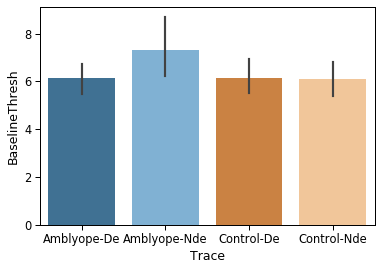

In [63]:
sns.barplot(data=baseline_df_withinsubject, x="Trace", y="BaselineThresh", palette=colors4)

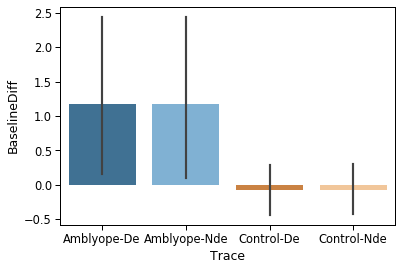

In [64]:
sns.barplot(data=baseline_df_withinsubject, x="Trace", y="BaselineDiff", palette=colors4)

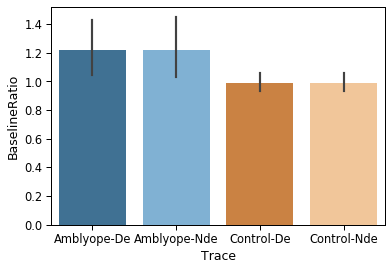

In [65]:
sns.barplot(data=baseline_df_withinsubject, x="Trace", y="BaselineRatio", palette=colors4)

### Begin within subject error bars, suggested by MAS 3/25

In [66]:
baseline_df_withinsubject # our starting data frame

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,Amblyope,ah,De,Amblyope-De,7.590,-3.032,0.600527
129,SS,Iso,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,-3.032,0.600527
130,SS,Iso,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.302,1.040096
131,SS,Iso,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,0.302,1.040096
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,2.314,1.295643
133,SS,Iso,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,2.314,1.295643
134,SS,Iso,nDicho,Amblyope,cl,De,Amblyope-De,6.709,0.749,1.111641
135,SS,Iso,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,0.749,1.111641
136,SS,Iso,nDicho,Amblyope,eg,De,Amblyope-De,6.826,-0.039,0.994287
137,SS,Iso,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,-0.039,0.994287


In [67]:
baseline_df_withinsubject.groupby("Trace").mean()

,BaselineThresh,BaselineDiff,BaselineRatio
Trace,,,
Amblyope-De,6.136462,1.181923,1.221562
Amblyope-Nde,7.318385,1.181923,1.221562
Control-De,6.153313,-0.075125,0.992533
Control-Nde,6.078188,-0.075125,0.992533


Strategy could then be to normalize everyone within a trace (group) to the mean and then measure error?

### old pre-4/28 stuff follows

In [68]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'])['BaselineDiff','BaselineRatio'].mean().reset_index()
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,Amblyope,ah,-3.032,0.600527
1,Amblyope,am,0.302,1.040096
2,Amblyope,bi,2.314,1.295643
3,Amblyope,cl,0.749,1.111641
4,Amblyope,eg,-0.039,0.994287
5,Amblyope,em,0.065,1.010926
6,Amblyope,gd,0.326,1.052496
7,Amblyope,jv,0.537,1.127040
8,Amblyope,li,3.253,1.800640
9,Amblyope,mg,1.480,1.354576


###  What if we exclude subject 'ah' who looks like a real outlier?

In [69]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=='Amblyope') &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")]
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=='Control']

In [70]:
print("diffs: NDE-DE")
print(st.ttest_1samp(adiff['BaselineDiff'], popmean=0), len(adiff['BaselineDiff']))
print(st.ttest_1samp(cdiff['BaselineDiff'], popmean=0), len(cdiff['BaselineDiff']))
print(st.ttest_ind(adiff['BaselineDiff'], cdiff['BaselineDiff']))
print("\nratios: NDE/DE")
print(st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print(st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print(st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))

diffs: NDE-DE
Ttest_1sampResult(statistic=2.6072499345735856, pvalue=0.024376781394930578) 12
Ttest_1sampResult(statistic=-0.3914078163041463, pvalue=0.7009997608059425) 16
Ttest_indResult(statistic=2.9092346026494287, pvalue=0.007327833537838833)

ratios: NDE/DE
Ttest_1sampResult(statistic=2.6759182869040514, pvalue=0.021564848189685275)
Ttest_1sampResult(statistic=-0.22134622628575037, pvalue=0.8278078450518194)
Ttest_indResult(statistic=2.918520108625676, pvalue=0.0071661206911115246)


### Ok based on conversation with Michael, 'ah' is excluded now

In [71]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah']
df_to_model = df_to_model[df_to_model.Subject!='ah']

In [72]:
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
1,Amblyope,am,0.302,1.040096
2,Amblyope,bi,2.314,1.295643
3,Amblyope,cl,0.749,1.111641
4,Amblyope,eg,-0.039,0.994287
5,Amblyope,em,0.065,1.010926
6,Amblyope,gd,0.326,1.052496
7,Amblyope,jv,0.537,1.127040
8,Amblyope,li,3.253,1.800640
9,Amblyope,mg,1.480,1.354576
10,Amblyope,mv,-0.037,0.993814


//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0, 0.5, 'Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')

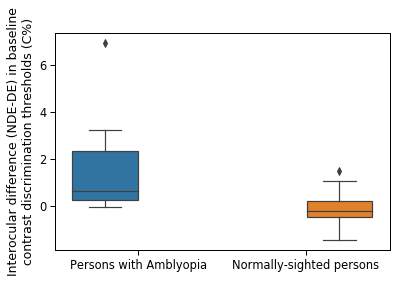

In [73]:
baseline_df_withinsubject_diffs.Population = baseline_df_withinsubject_diffs.Population.astype('category').cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])
g = sns.boxplot(data=baseline_df_withinsubject_diffs, x='Population', y='BaselineDiff', hue='Population')
g.legend().remove()
#g.legend().set_title('')
g.set_xlabel('')
g.set_ylabel('Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')

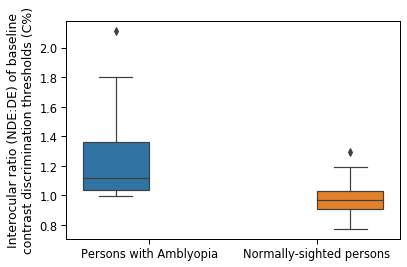

In [74]:
g = sns.boxplot(data=baseline_df_withinsubject_diffs, x='Population', y='BaselineRatio', hue='Population')
g.legend().remove()
g.set_xlabel('')
g.set_ylabel('Interocular ratio (NDE:DE) of baseline\ncontrast discrimination thresholds (C%)')
#g.set_yscale('log')
#g.set_ylim(0.5, 3)
#g.get_yaxis().set_major_locator(tick.LogLocator(subs=range(1, 10)))
g.get_yaxis().set_major_formatter(tick.ScalarFormatter())


In [75]:
baseline_df_withinsubject_diffs.groupby(['Population']).describe()

BaselineDiff                                      \
                                count      mean       std    min      25%   
Population                                                                  
Persons with Amblyopia           12.0  1.533083  2.036919 -0.039  0.24275   
Normally-sighted persons         16.0 -0.075125  0.767741 -1.453 -0.47700   

                                                BaselineRatio            \
                            50%      75%    max         count      mean   
Population                                                                
Persons with Amblyopia    0.643  2.35625  6.964          12.0  1.273315   
Normally-sighted persons -0.198  0.19950  1.473          16.0  0.992533   

                                                                            \
                               std       min       25%       50%       75%   
Population                                                                   
Persons with Amblyopia    0.353819  0.993814  1.032803  1.119341  1.362562   
Normally-sighted persons  0.134933  0.774609  0.909571  0.967698  1.032396   

                                    
                               max  
Population                          
Persons with Amblyopia    2.112105  
Normally-sighted persons  1.295486

### Make bar chart

In [76]:
baseline_df_reduced

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
0,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.136462,1.230422,0.341258
1,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.318385,2.271492,0.629998
2,SS,Iso,nDicho,Control,De,Control-De,16.0,6.153313,1.508262,0.377066
3,SS,Iso,nDicho,Control,Nde,Control-Nde,16.0,6.078188,1.447952,0.361988


In [77]:
baseline_plot_df = utils.make_baseline_df_to_plot(baseline_df_reduced, 'mean')

In [78]:
baseline_plot_df.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM,BaselineDiff,BaselineRatio
0,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.136462,1.230422,0.341258,1.181923,1.192607
1,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.318385,2.271492,0.629998,1.181923,1.192607
2,SS,Iso,nDicho,Control,De,Control-De,16.0,6.153313,1.508262,0.377066,-0.075125,0.987791
3,SS,Iso,nDicho,Control,Nde,Control-Nde,16.0,6.078188,1.447952,0.361988,-0.075125,0.987791


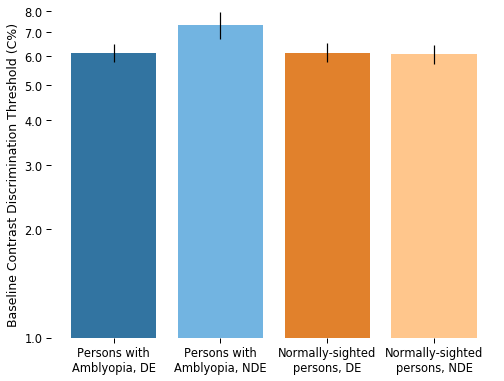

In [79]:
with s.PdfPages(f"{plot_dir}/{task}_baseline_diffs_group.pdf") as pdf:
    sns.set_context(context="paper", font_scale=1.3)
    fig = plt.figure(figsize=(8,6))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    x_pos = np.arange(len(baseline_plot_df['Population']))
    plt.bar(x_pos, baseline_plot_df['mean'], data=baseline_plot_df, yerr='SEM', color=colors4)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(traces_graph4)
    ax.set_ylabel('Baseline Contrast Discrimination Threshold (C%)')
    ax.set_yscale('log')
    ax.set_ylim(1, 8)
    ax.get_yaxis().set_major_locator(tick.LogLocator(subs=range(1, 10)))
    ax.get_yaxis().set_major_formatter(tick.ScalarFormatter())
    sns.despine(left=True, bottom=True, right=True, top=True)
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

## Actual fitting of model to contrast sensitivity curves
### Linear model using statsmodels

In [80]:
lin_results = groups_with_baseline.apply(utils.linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [81]:
lin_results.head(n=16)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


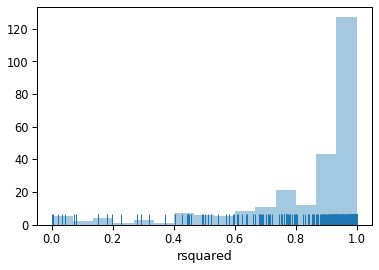

In [82]:
sns.distplot(lin_results.rsquared, kde=False, rug=True)

In [83]:
np.count_nonzero(lin_results.rsquared>.999999)

0

In [84]:
lin_results.rsquared.mean()

0.8354424459253054

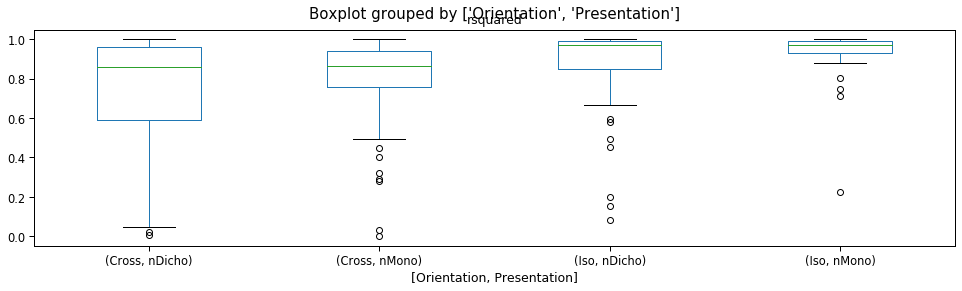

In [85]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Presentation'], grid=False, figsize=(16, 4))

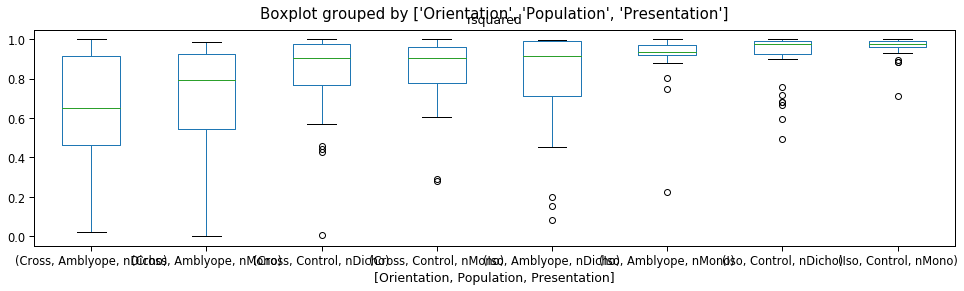

In [86]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

### Fit the log-logged data to see if that's better

In [87]:
log_results = groups_with_baseline.apply(utils.linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

log_results.rsquared.mean()

0.7417445472530506

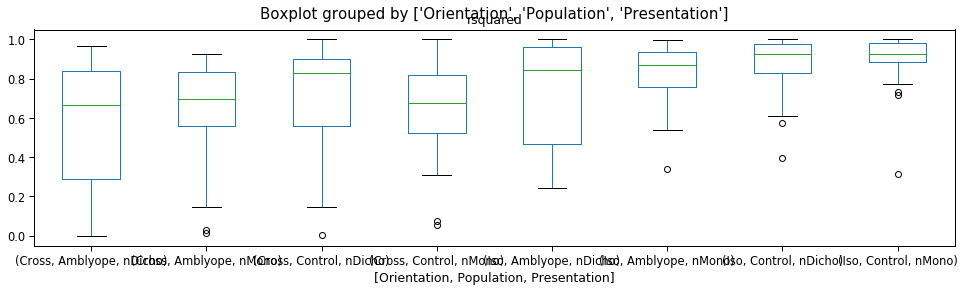

In [88]:
log_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

## Conclusion: linear fits are overall better.

## Identify subjects with negative slope (for Jian)

In [89]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [90]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

## Exclude bad fits (new 2019-02-25)

In [91]:
len(lin_results)

256

In [92]:
lin_results_exc = lin_results.groupby(['Task', 'Population']).apply(utils.remove_outliers_halfvar).reset_index(drop=True)

In [93]:
lin_results_exc.rsquared.min()

0.5030976163556411

In [94]:
lin_results_exc.Subject.value_counts().sum()

231

In [95]:
231/256

0.90234375

In [96]:
pp_subs_exc = lin_results_exc.Subject.unique()
print(f'There are {len(pp_subs_exc)} unique subjects who have at least one condition of data.')

There are 35 unique subjects who have at least one condition of data.


## Actually use the linear model to predict thresholds

In [97]:
lin_preds = groups_with_baseline.apply(utils.linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [98]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [99]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [100]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])

plot_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,ThreshPred
0,ai,SS,nMono,Iso,De,Control,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2,-0.211125,0.161068,0.475863
1,ai,SS,nMono,Iso,De,Control,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4,-0.173277,0.638290,0.897104
2,ai,SS,nMono,Iso,De,Control,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6,0.219585,0.953566,1.571032
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277,0.656604
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527,0.977298


### Plot observed values and model fits

In [101]:
example_fit_plot_df = plot_df[(plot_df.Subject=='gd') & 
                              (plot_df.Orientation=='Iso') & 
                              (plot_df.Presentation=='nDicho')]
example_fit_plot_df

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,ThreshPred
579,gd,SS,nDicho,Iso,Nde,Amblyope,5.0,1.125,0.009,0.805,Amblyope-Nde,6.536,0.792,1,0.051153,-0.094204,0.636038
580,gd,SS,nDicho,Iso,Nde,Amblyope,10.0,1.215,0.010,1.610,Amblyope-Nde,6.536,1.460,2,0.084576,0.206826,1.243600
581,gd,SS,nDicho,Iso,Nde,Amblyope,18.0,1.733,0.010,2.899,Amblyope-Nde,6.536,2.632,3,0.238799,0.462248,2.216453
582,gd,SS,nDicho,Iso,Nde,Amblyope,32.0,3.494,0.016,5.153,Amblyope-Nde,6.536,4.526,4,0.543323,0.712060,3.917625
583,gd,SS,nDicho,Iso,Nde,Amblyope,45.0,5.944,0.007,7.246,Amblyope-Nde,6.536,7.257,5,0.774079,0.860098,5.497285
680,gd,SS,nDicho,Iso,De,Amblyope,5.0,0.787,0.009,0.765,Amblyope-De,6.210,0.878,2,-0.104025,-0.116339,1.026201
681,gd,SS,nDicho,Iso,De,Amblyope,10.0,1.121,0.008,1.530,Amblyope-De,6.210,1.496,3,0.049606,0.184691,1.042671
682,gd,SS,nDicho,Iso,De,Amblyope,18.0,1.294,0.012,2.754,Amblyope-De,6.210,2.500,4,0.111934,0.439964,1.069024
683,gd,SS,nDicho,Iso,De,Amblyope,32.0,1.173,0.007,4.896,Amblyope-De,6.210,4.330,5,0.069298,0.689841,1.115141
684,gd,SS,nDicho,Iso,De,Amblyope,45.0,1.036,0.009,6.885,Amblyope-De,6.210,6.995,6,0.015360,0.837904,1.157963


In [102]:
s.group_facet_plots(example_fit_plot_df, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation',"Subject"], #each combo of this gets its own page
                    row='Presentation', col="Population",# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Eye",yerr='ThreshElev_SE',fmt_obs='x',fmt_pred=':',Ycol="ThreshPred") 

RelMaskContrast ThreshElev [0.009 0.01  0.01  0.016 0.007] ThreshPred
RelMaskContrast ThreshElev [0.009 0.008 0.012 0.007 0.009] ThreshPred
Plotting SS.Iso.nDicho.gd
Plots saved at plots/redo-202001-mean_occ_all-fixeyes/SS_regressions_combinedplots_n35_TOP.pdf


In [103]:
#s.group_facet_plots(plot_df, s.population_fit_plot,
#                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
#                    ['Task','Orientation'], #each combo of this gets its own page
#                    row='Presentation',col='Eye',# facet rows and columns
#                    x="RelMaskContrast", y="ThreshElev", # x, y
#                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

## Now exclude the predictions for the bad fits

In [104]:
lin_results.Orientation.value_counts()

Cross    128
Iso      128
Name: Orientation, dtype: int64

In [105]:
lin_results_exc.Orientation.value_counts()

Iso      122
Cross    109
Name: Orientation, dtype: int64

In [106]:
lin_results_exc.Population.value_counts()

Control     145
Amblyope     86
Name: Population, dtype: int64

In [107]:
lin_results.Population.value_counts()

Control     152
Amblyope    104
Name: Population, dtype: int64

In [108]:
comb_rsq_preds = pd.merge(lin_results_exc, lin_preds, on=pp_gvars_base)

In [109]:
comb_rsq_preds.rsquared.min()

0.5030976163556411

In [110]:
comb_rsq_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


In [111]:
comb_rsq_preds_noexc = pd.merge(lin_results, lin_preds, on=pp_gvars_base)

In [112]:
comb_rsq_preds_noexc.rsquared.min()

0.002508814671685511

In [113]:
comb_rsq_preds_noexc.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [114]:
percentile_bins = np.linspace(0, 1, num=11)

In [115]:
percentile_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [116]:
relmc_pcts_df = comb_rsq_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [117]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [118]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [119]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   
                                                 Nde Amblyope-Nde 10.141          1.278   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   
                                                 Nde Amblyope-Nde 10.141          1.7890   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   
                                                 Nde Amblyope-Nde 10.141          2.3000   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   
                                                 Nde Amblyope-Nde 10.141          2.8110   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   
                                                 Nde Amblyope-Nde 10.141          3.3220   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   
                                                 Nde Amblyope-Nde 10.141          3.8330   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [120]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [121]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [122]:
relmc_pcts_df_melted.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,000,2.194
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,000,1.318
2,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,000,1.328
3,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,000,0.986
4,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,000,1.278


In [123]:
predict_pcts_df = pd.merge(lin_results_exc, relmc_pcts_df_melted, on=pp_gvars_base)

In [124]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [125]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [126]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


In [127]:
predict_pcts_df.rsquared.min()

0.5030976163556411

In [128]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p-value: 0.0001217267
10 DE obs, 17 NDE obs
p-value: 0.0026591129
8 DE obs, 14 NDE obs
p-value: 0.0073737492
8 DE obs, 12 NDE obs
p-value: 0.0344970562
4 DE obs, 13 NDE obs
p-value: 0.0082892146
2 DE obs, 8 NDE obs
p-value: 0.0336034718
3 DE obs, 4 NDE obs
p-value: 0.3643803918
3 DE obs, 5 NDE obs
p-value: 0.0423860511
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 4 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.3205767408
A group with no obs, skipping
A group with no obs, skipping
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 24 bins in this condition.
7 DE obs, 14 NDE obs
p-value: 0.5173489421
7 DE obs, 14 NDE obs
p-value: 0.5173489421
22 DE obs, 31 NDE obs
p-value: 0.2087782894
21 DE obs, 34 NDE obs
p-value: 0.4025978400
17 DE obs, 22 NDE obs
p-value: 0.5009762075
16 DE obs, 19 NDE obs
p-value: 0.9672675535
10 DE obs, 17 NDE obs
p-value: 0.4709410102
9 DE obs, 13 NDE obs
p-value: 0.7726435799
9 DE obs, 12 NDE obs
p-value: 0.6928377773
7 DE obs, 7 NDE obs
p-value: 0.6129804962
6 DE obs, 10 NDE obs
p-value: 0.3569340741
3 DE obs, 8 NDE obs
p-value: 0.1567434426
5 DE obs, 5 NDE obs
p-value: 0.4204986492
4 DE obs, 5 NDE obs
p-value: 0.0351302295
3 DE obs, 3 NDE obs
p-value: 0.5147506073
4 DE obs, 5 NDE obs
p-value: 0.1457780541
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 3 NDE obs
p-value: nan
2 DE obs, 1 NDE obs
p-value: nan
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 2 NDE obs
p-value: nan
2 DE obs, 1 NDE ob

464               2.1776          2        1.723391                2  
     Task Orientation Presentation Population Subject Eye       Trace  \
1766   SS         Iso       nDicho    Control      cr  De  Control-De   
1868   SS         Iso       nDicho    Control      gm  De  Control-De   
1978   SS         Iso       nDicho    Control      mk  De  Control-De   
2089   SS         Iso       nDicho    Control      tm  De  Control-De   

      BaselineThresh     y_int     slope  rsquared  percentile  \
1766           4.033 -0.309219  0.244800  0.954217          60   
1868           6.630  0.518978  0.207153  0.975947          90   
1978           5.552  0.568495  0.154643  0.994142          90   
2089           6.892  1.104551  0.156695  0.970204         100   

      RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
1766              12.7412         13        2.809827               13  
1868              12.7724         13        3.164813               13  
1978            

In [129]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [130]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         209.0  2.0  0.0  2.0  2.0  2.0   
                              Control          374.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         220.0  2.0  0.0  2.0  2.0  2.0   
                              Control          396.0  2.0  0.0  2.0  2.0  2.0   
     Iso         nDicho       Amblyope         242.0  2.0  0.0  2.0  2.0  2.0   
                              Control          407.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         275.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          209.0  1.405147   
                              Control     2.0  2.0          374.0  1.270859   
                 nMono        Amblyope    2.0  2.0          220.0  1.016782   
                              Control     2.0  2.0          396.0  0.967216   
     Iso         nDicho       Amblyope    2.0  2.0          242.0  1.683927   
                              Control     2.0  2.0          407.0  1.974481   
                 nMono        Amblyope    2.0  2.0          275.0  1.437772   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.625566  0.676956  1.012935   
                              Control     0.445897  0.661363  0.939387   
                 nMono        Amblyope    0.314906  0.344715  0.846435   
                              Control     0.262268  0.430126  0.795938   
     Iso         nDicho       Amblyope    1.136489  0.260012  1.023047   
                              Control     0.890109  0.474386  1.343264   
                 nMono        Amblyope    0.824721  0.366306  0.861253   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.226023  1.565376  4.674826  
                              Control     1.184204  1.470286  3.959224  
                 nMono        Amblyope    0.999258  1.168597  2.219274  
                              Control     0.930215  1.111265  2.078230  
     Iso         nDicho       Amblyope    1.322546  2.025497  6.242498  
                              Control     1.806443  2.409358  5.881773  
                 nMono        Amblyope    1.157459  1.806846  4.903989  
                              Control     1.300831  1.972276  6.689321

In [131]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [132]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


In [133]:
individual_plot_df = selected_bin_df[(selected_bin_df.Subject=='sd') & (selected_bin_df.Presentation=='nDicho') &
                (selected_bin_df.Orientation=='Iso')]

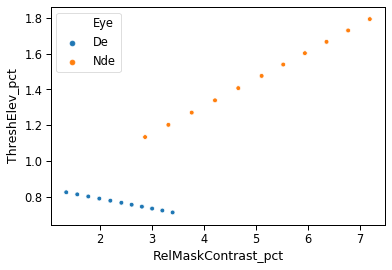

In [134]:
sns.scatterplot(data=individual_plot_df, x="RelMaskContrast_pct", y="ThreshElev_pct", hue="Eye")

### Melt the result of the modeling into long format for plotting

In [135]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=[*pp_gvars, 'rsquared'],
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub = pfit_all_ppsub[pfit_all_ppsub.Subject != 'ah']
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
23,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
24,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
25,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834
26,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,0.878492,BaselineThresh,7.834


In [136]:
pp_stats = pfit_all_ppsub[(pfit_all_ppsub.measure=="ThreshPredCritical")].drop_duplicates()

In [137]:
pp_slopes = pfit_all_ppsub[pfit_all_ppsub.measure=="slope"].drop_duplicates()

In [138]:
pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace','Subject','measure'])['value'].describe(percentiles=[.5])

count  \
Task Orientation Presentation Population Eye Trace        Subject measure                     
SS   Cross       nDicho       Amblyope   De  Amblyope-De  bi      ThreshPredCritical    1.0   
                                                          cl      ThreshPredCritical    1.0   
                                                          eg      ThreshPredCritical    1.0   
                                                          li      ThreshPredCritical    1.0   
                                                          mv      ThreshPredCritical    1.0   
                                         Nde Amblyope-Nde am      ThreshPredCritical    1.0   
                                                          bi      ThreshPredCritical    1.0   
                                                          cl      ThreshPredCritical    1.0   
                                                          eg      ThreshPredCritical    1.0   
                                                          em      ThreshPredCritical    1.0   
                                                          gd      ThreshPredCritical    1.0   
                                                          jv      ThreshPredCritical    1.0   
                                                          li      ThreshPredCritical    1.0   
                                                          mg      ThreshPredCritical    1.0   
                                                          mv      ThreshPredCritical    1.0   
                                                          rn      ThreshPredCritical    1.0   
                                                          sd      ThreshPredCritical    1.0   
                              Control    De  Control-De   ai      ThreshPredCritical    1.0   
                                                          cr      ThreshPredCritical    1.0   
                                                          ct      ThreshPredCritical    1.0   
                                                          ei      ThreshPredCritical    1.0   
                                                          es      ThreshPredCritical    1.0   
                                                          gm      ThreshPredCritical    1.0   
                                                          kw      ThreshPredCritical    1.0   
                                                          ls      ThreshPredCritical    1.0   
                                                          mk      ThreshPredCritical    1.0   
                                                          ms      ThreshPredCritical    1.0   
                                                          nl      ThreshPredCritical    1.0   
                                                          se      ThreshPredCritical    1.0   
                                                          tm      ThreshPredCritical    1.0   
...                                                                                     ...   
     Iso         nMono        Control    De  Control-De   kw      ThreshPredCritical    1.0   
                                                          ls      ThreshPredCritical    1.0   
                                                          mk      ThreshPredCritical    1.0   
                                                          ms      ThreshPredCritical    1.0   
                                                          nl      ThreshPredCritical    1.0   
                                                          se      ThreshPredCritical    1.0   
                                                          tm      ThreshPredCritical    1.0   
                                                          yl      ThreshPredCritical    1.0   
                                         Nde Control-Nde  ai      ThreshPredCritical    1.0   
                                                          ap      ThreshPredCritical    1.0   
 

In [139]:
def test_suppression_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['value'])
    des = np.unique(g[g.Eye=='De']['value'])
    #g.hist()
    print(len(ndes), ' ', len(des))
    print(st.ttest_ind(ndes, des))
    return st.ttest_ind(ndes, des)

gs = pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'measure'])
for gv, g in gs:
    if gv[-1] == 'ThreshPredCritical':
        print(gv)
        test_suppression_diffs(g)
        #test_suppression_diffs_withinsubject(g)

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
12   5
Ttest_indResult(statistic=0.7299650938121938, pvalue=0.47665772477441826)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
20   14
Ttest_indResult(statistic=1.2480432813668088, pvalue=0.2210704712855009)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
8   10
Ttest_indResult(statistic=2.168794020213688, pvalue=0.04551308680649891)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
22   14
Ttest_indResult(statistic=0.017806935418218775, pvalue=0.9858969600137633)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
11   9
Ttest_indResult(statistic=1.6457568302805612, pvalue=0.11716250467180517)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
22   15
Ttest_indResult(statistic=0.8733956494629632, pvalue=0.3884006830868616)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
11   12
Ttest_indResult(statistic=1.629629014967295, pvalue=0.11808930769833965)
('SS', 'Iso', 'nMono', '

## Subset to include only (GABA and psychophyics) subjects

In [140]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [141]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [142]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='Persons with Amblyopia'])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are Amblyopes.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are Amblyopes.


In [143]:
stats_thistask = lin_results_exc[lin_results_exc.Subject.isin(gaba_and_pp_subjs_thistask)].groupby(['Subject'])['rsquared'].describe()

In [144]:
stats_thistask

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
ai,8.0,0.935161,0.117607,0.659733,0.943784,0.986299,0.999719,0.999922
am,6.0,0.910557,0.067258,0.799772,0.887612,0.915914,0.949502,0.992865
bi,7.0,0.916000,0.164366,0.546837,0.952287,0.976332,0.992383,0.999488
cr,8.0,0.945987,0.058601,0.840411,0.904833,0.963965,0.997742,0.999292
ct,7.0,0.937913,0.077187,0.779726,0.926199,0.964989,0.985442,0.997392
dl,6.0,0.893841,0.092011,0.770530,0.821866,0.911476,0.969726,0.988424
ei,7.0,0.922415,0.140298,0.607023,0.954326,0.973990,0.983801,0.999641
em,7.0,0.885701,0.098248,0.745585,0.809151,0.921243,0.957915,0.998944
es,7.0,0.779242,0.124372,0.596832,0.697413,0.766640,0.881903,0.932588


In [145]:
n_gaba_and_pp_subjs_thistask * 8 - stats_thistask['count'].sum()

25.0

## Combine Psychophysics and GABA below

In [146]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))


1115 765


In [147]:
comb_gabappsub.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

### Do Spearman's R

In [148]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | 
                             (comb_gabappsub.measure == 'ThreshPredCritical')]

In [149]:
spearman_df.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

In [150]:
spearman_df.Trace = spearman_df.Trace.astype('category')
foo_temp = spearman_df.Trace.copy()
spearman_df.Trace.cat.reorder_categories(traces4, inplace=True)
assert(foo_temp.equals(spearman_df.Trace))
spearman_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [151]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye','Trace'])
for gv, gr in plot_groups:
    #if 'nDicho' in gv:
    print(gv)
    print(stats.spearmanr(gr.GABA, gr.value))

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'Nde', 'Persons with\nAmblyopia, NDE')
SpearmanrResult(correlation=-0.2142857142857143, pvalue=0.6103444156452669)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'Nde', 'Persons with\nAmblyopia, NDE')
SpearmanrResult(correlation=-0.38095238095238104, pvalue=0.35181255311756476)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'De', 'Normally-sighted\npersons, DE')
SpearmanrResult(correlation=0.18213688176797005, pvalue=0.5710157812668486)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'Nde', 'Normally-sighted\npersons, NDE')
SpearmanrResult(correlation=0.14685314685314685, pvalue=0.6487957097846664)

In [152]:
#graphs!
colors_a = ["#3274a1","#72b4e1"]
colors_c = ["#e1812c", "#ffc68c"]
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}.pdf") as pdf:
    plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure'])
    plot_groups_eacheye = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye'])
    for gv, gr in plot_groups:
        #if gv[2] == 'nDicho':
        print(gv, np.all(np.isnan(gr['value'])), len(gr['value']))
        pal = [colors_a if 'Amblyope' in gv else colors_c]
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal[0], aspect=1.2)
        pdf.savefig(g2.fig)

plt.close('all')

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh') False 10
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 10
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh') False 24
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical') False 24
('SS', 'Cross', 'nMono', 'Amblyope', 'BaselineThresh') False 11
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical') False 11
('SS', 'Cross', 'nMono', 'Control', 'BaselineThresh') False 26
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical') False 26
('SS', 'Iso', 'nDicho', 'Amblyope', 'BaselineThresh') False 12
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 12
('SS', 'Iso', 'nDicho', 'Control', 'BaselineThresh') False 27
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical') False 27
('SS', 'Iso', 'nMono', 'Amblyope', 'BaselineThresh') False 15
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical') False 15
('SS', 'Iso', 'nMono', 'Control', 'BaselineThresh') False 28
('SS', 'Iso', 'nMono', 'C

In [153]:
# with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_ind.pdf") as pdf:
#     for gv, gr in plot_groups:
#         print(gv)
#         g = s.gaba_vs_psychophys_plot(gv, gr, hue="Eye",
#                     palette=dict(De="g", Nde="m"),
#                     n_boot=1000, height=8, aspect=1, legend_out=True, truncate=True)
#         g.fig.suptitle(f"{gv} unweighted", fontsize=10, y=0.999)
#         pdf.savefig(g.fig)
#         plt.close('all')

In [154]:
facet_groups = spearman_df.groupby(['Task','Orientation','Presentation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet.pdf") as pdf:
    for gv, gr in facet_groups:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr, 
                    legend_box=[0.9, 0.60, 0.1, 0.15],
                    legend_img = False,
                    log = False,
                    col="Population", hue="Trace",
                    palette=colors4,
                    n_boot=1000,
                    markers=['o','s','o','s'])#, legend=False)
        g.set_titles("")
        g.fig.subplots_adjust(left=.08, right=.82, wspace=0.1)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'ThreshPredCritical')
('SS', 'Cross', 'nMono', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'ThreshPredCritical')
('SS', 'Iso', 'nMono', 'ThreshPredCritical')


In [218]:
facet_groups2 = spearman_df.groupby(['Task','Orientation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet_joint.pdf") as pdf:
    for gv, gr in facet_groups2:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr, 
                    legend_box=[0.9, 0.60, 0.1, 0.15],
                    legend_img = False,
                    log = True,
                    sharex=False, sharey=False,
                    #ylim = (1, 50),
                    row="Presentation", col="Population", hue="Trace",
                    palette=colors4,
                    n_boot=5000,
                    markers=['o','s','o','s'])#, legend=False)
        g.set_titles("")
        g.fig.subplots_adjust(left=.08, right=.82, wspace=0.1)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')
('SS', 'Iso', 'ThreshPredCritical')


In [156]:
spearman_supp_df = spearman_df[spearman_df.measure=="ThreshPredCritical"]
supp_facet_groups = spearman_supp_df.groupby(['Task','Orientation','Presentation','measure'])

In [157]:
rdiffs_nores = supp_facet_groups.apply(utils.compare_rs, n_boot=1000, resample=False).reset_index()\
            .rename(columns={"level_4":"iteration"})



****('SS', 'Cross', 'nDicho', 'ThreshPredCritical')*****


Percentiles for individual eye correlations:
Amb DE 
Observed value of 1.000 is greater than 0.484 of bootstrap distribution, corresponding to p=0.968.
Amb NDE 
Observed value of -0.381 is greater than 0.154 of bootstrap distribution, corresponding to p=0.308.
Con DE 
Observed value of -0.154 is greater than 0.336 of bootstrap distribution, corresponding to p=0.672.
Con NDE 
Observed value of -0.077 is greater than 0.416 of bootstrap distribution, corresponding to p=0.832.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -1.381 is greater than 0.086 of bootstrap distribution, corresponding to p=0.172.
Con NDE vs DE 
Observed value of 0.077 is greater than 0.570 of bootstrap distribution, corresponding to p=0.860.
Pop Amb vs Con 
Observed value of -1.458 is greater than 0.125 of bootstrap distribution, corresponding to p=0.250.


****('SS', 'Cross', 'nDicho', 'ThreshPredCritical')*****


Percentiles 

In [158]:
# checking if the .015 p-val for SS/Iso/Dicho/AMB/Nde/ThreshPredCritical survives multicomp
pvals = np.array([0.0, 0.015, 0.08, 0.1, 0.15, 0.17, 0.2, 0.22, 0.25, 0.3, 0.33, 0.37, 0.4, 0.44, 0.47, 0.5])
print(pvals)
mt.multipletests(pvals, 0.05, 'holm')

[0.    0.015 0.08  0.1   0.15  0.17  0.2   0.22  0.25  0.3   0.33  0.37
 0.4   0.44  0.47  0.5  ]


(array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([0.   , 0.225, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ]),
 0.0032006977101884937,
 0.003125)

In [159]:
rdiffs = rdiffs_nores

In [160]:
rdiffs_supp = rdiffs[rdiffs['measure']=="ThreshPredCritical"]
rdiffs_supp.head()

,Task,Orientation,Presentation,measure,iteration,amb_rdiff,con_rdiff,pop_rdiff
0,SS,Cross,nDicho,ThreshPredCritical,0,-0.880952,-0.321666,-0.559286
1,SS,Cross,nDicho,ThreshPredCritical,1,-0.500000,0.151103,-0.651103
2,SS,Cross,nDicho,ThreshPredCritical,2,-1.047619,0.490185,-1.537804
3,SS,Cross,nDicho,ThreshPredCritical,3,1.095238,-0.349871,1.445109
4,SS,Cross,nDicho,ThreshPredCritical,4,-0.357143,-0.836749,0.479606


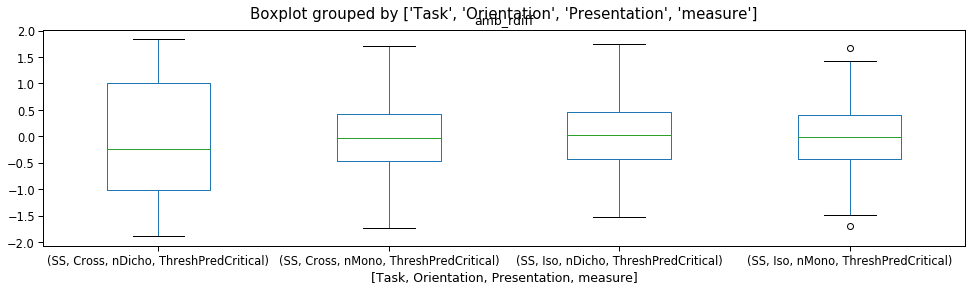

In [161]:
rdiffs_supp.boxplot(column='amb_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a200c9160>,
      dtype=object)

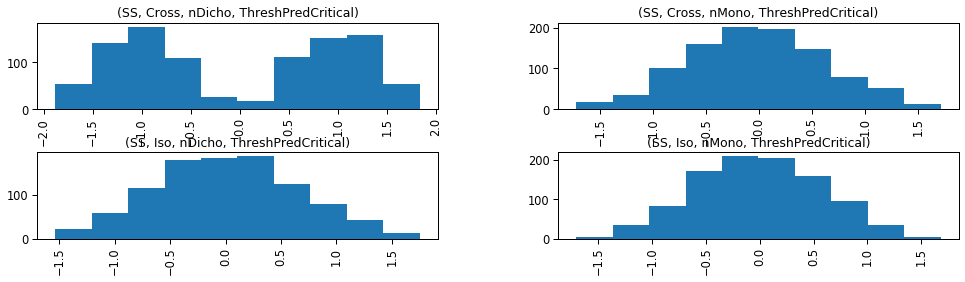

In [162]:
# Rho(GABA vs ThreshElev(NDE)) - Rho(GABA vs ThreshElev(DE)) for Amblyopes only, by condition
rdiffs_supp.hist(column='amb_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

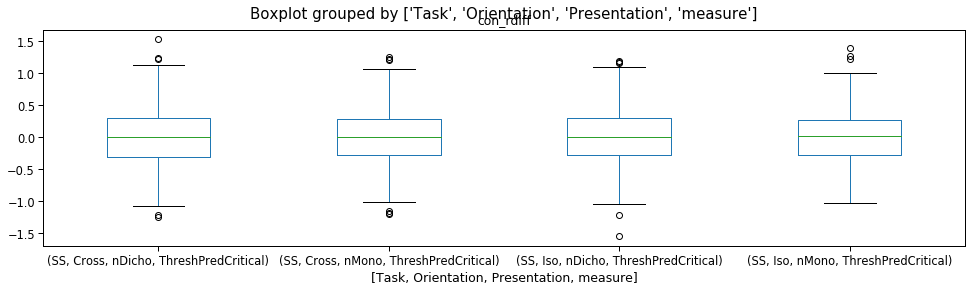

In [163]:
rdiffs_supp.boxplot(column='con_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

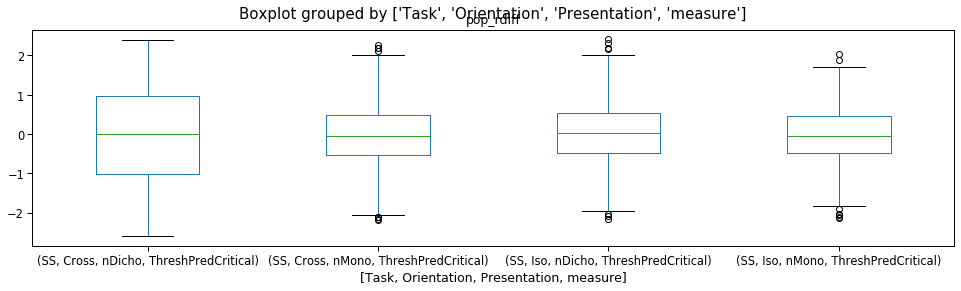

In [164]:
rdiffs_supp.boxplot(column='pop_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

In [165]:
comb_gabappsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,0.865440,BaselineThresh,4.764,0.201


In [166]:
spearman_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,"Persons with\nAmblyopia, DE",0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,"Persons with\nAmblyopia, NDE",0.865440,BaselineThresh,4.764,0.201


In [167]:
spearman_df.measure.unique()

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [168]:
kelly_file = f"{plot_dir}/{task}_data_frame.csv"
spearman_df.to_csv(kelly_file)

### Orientation Selective Suppression

In [169]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace",
             "measure", "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", 
             "measure", "GABA"]

In [170]:
for gv, g in spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars):
    print(gv, g.Orientation.unique())

('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.205) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.185) ['Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.185) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'gd', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.19699999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.201) ['Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.201) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.21600000000000003) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'Nde', 'Persons with\nAmbly

In [171]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Orientation', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std  \
Task Orientation Presentation Population Eye                              
SS   Cross       nDicho       Amblyope   De     2.0  0.957207  0.095512   
                                         Nde    8.0  1.118438  0.602485   
                              Control    De    12.0  0.920188  0.222444   
                                         Nde   12.0  1.000823  0.214008   
                 nMono        Amblyope   De     6.0  0.845055  0.131815   
                                         Nde    5.0  0.969276  0.211546   
                              Control    De    12.0  0.763950  0.153710   
                                         Nde   14.0  0.773161  0.159849   
     Iso         nDicho       Amblyope   De     5.0  0.826099  0.143298   
                                         Nde    7.0  1.210034  0.525613   
                              Control    De    13.0  1.162128  0.526390   
                                         Nde   14.0  1.299467  0.409784   
                 nMono        Amblyope   De     8.0  0.866610  0.216900   
                                         Nde    7.0  0.974545  0.213291   
                              Control    De    14.0  0.759316  0.205264   
                                         Nde   14.0  0.791336  0.181914   

                                                   min       25%       50%  \
Task Orientation Presentation Population Eye                                 
SS   Cross       nDicho       Amblyope   De   0.889669  0.923438  0.957207   
                                         Nde  0.297554  0.855251  1.097689   
                              Control    De   0.566634  0.752102  0.902277   
                                         Nde  0.710565  0.836442  0.987619   
                 nMono        Amblyope   De   0.618131  0.808101  0.855103   
                                         Nde  0.601685  0.988664  1.047289   
                              Control    De   0.531982  0.659041  0.782763   
                                         Nde  0.469253  0.707193  0.755307   
     Iso         nDicho       Amblyope   De   0.683123  0.722384  0.788769   
                                         Nde  0.454030  0.906793  1.282176   
                              Control    De   0.180381  0.877780  1.097869   
                                         Nde  0.833085  0.986137  1.285265   
                 nMono        Amblyope   De   0.572492  0.657065  0.920236   
                                         Nde  0.606465  0.878960  1.045415   
                              Control    De   0.472317  0.610172  0.750564   
                                         Nde  0.506221  0.678647  0.748844   

                                                   75%       max  
Task Orientation Presentation Population Eye                      
SS   Cross       nDicho       Amblyope   De   0.990975  1.024744  
                                         Nde  1.226792  2.367282  
                              Control    De   1.116148  1.198372  
                                         Nde  1.092446  1.458876  
                 nMono        Amblyope   De   0.941145  0.979736  
                                         Nde  1.082916  1.125824  
                              Control    De   0.853101  1.040694  
                                         Nde  0.896052  0.976262  
     Iso         nDicho       Amblyope   De   0.900248  1.035972  
                                         Nde  1.418028  2.084390  
                              Control    De   1.501505  2.191057  
                                         Nde  1.340348  2.269123  
                 nMono        Amblyope   De   1.014116  1.160384  
                                         Nde  1.119914  1.172186  
                              Control    De   0.924252  1.102926  
                                         Nde  0.869298  1.233350

In [172]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Presentation', 'Population','Eye'])['Subject'].describe()

count unique top freq
Task Presentation Population Eye                      
SS   nDicho       Amblyope   De      7      7  mg    1
                             Nde    15      8  mg    2
                  Control    De     25     14  nl    2
                             Nde    26     14  nl    2
     nMono        Amblyope   De     14      8  mg    2
                             Nde    12      7  mg    2
                  Control    De     26     14  nl    2
                             Nde    28     14  ai    2

In [173]:
oss_df = spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0805794306213783
Iso/Cross ratio: nan
Iso/Cross ratio: 0.8804992773062317
Iso/Cross ratio: 1.6746546243888554
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 0.3777062353868689
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2225842451824867
Iso/Cross ratio: nan
Iso/Cross ratio: 0.9855669521500559
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0054249110747602
Iso/Cross ratio: 1.441081746125601
Iso/Cross ratio: 1.4101357218055621
Iso/Cross ratio: 0.3183386415959459
Iso/Cross ratio: 0.7860277350761017
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0334808785607723
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2625513903058483
Iso/Cross ratio: 1.3991192980351077
Iso/Cross ratio: 1.1074330346930361
Iso/Cross ratio: 1.4973547772549172
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2271654371200194
Iso/Cross ratio: 1.2351557611759358
Iso/Cross ratio: nan
Iso/Cross ratio: 2.2838663786421733
Iso/Cross ratio: 1.121263370574786
Iso/Cross

In [174]:
print(np.count_nonzero(np.isnan(oss_df.value)), len(oss_df.value))

11901 11968


In [175]:
oss_df[~np.isnan(oss_df.value)]

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
230,SS,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.205,1.080579
901,SS,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.185,0.880499
1178,SS,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.197,1.674655
1866,SS,nDicho,Amblyope,li,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.216,0.377706
2139,SS,nDicho,Amblyope,mg,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.217,1.222584
2675,SS,nDicho,Amblyope,rn,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.200,0.985567
2806,SS,nDicho,Amblyope,sd,Nde,"Persons with\nAmblyopia, NDE",ThreshPredCritical,0.187,1.005425
3042,SS,nDicho,Control,ai,De,"Normally-sighted\npersons, DE",ThreshPredCritical,0.223,1.441082
3127,SS,nDicho,Control,ai,Nde,"Normally-sighted\npersons, NDE",ThreshPredCritical,0.223,1.410136
3305,SS,nDicho,Control,cr,De,"Normally-sighted\npersons, DE",ThreshPredCritical,0.201,0.318339


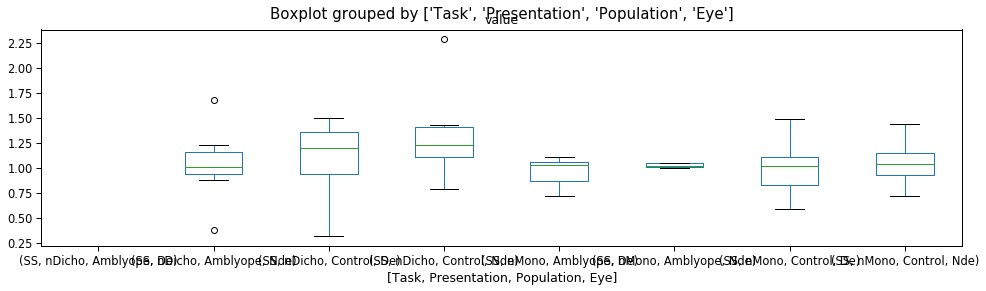

In [176]:
oss_df.boxplot(column='value', by=['Task','Presentation','Population','Eye'],
               grid=False, figsize=(16, 4))

In [177]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std       min  \
Task Presentation Population Eye                                        
SS   nDicho       Amblyope   De     0.0       NaN       NaN       NaN   
                             Nde    7.0  1.032431  0.388502  0.377706   
                  Control    De    11.0  1.116649  0.338898  0.318339   
                             Nde   12.0  1.287269  0.362879  0.786028   
     nMono        Amblyope   De     6.0  0.957098  0.157721  0.711143   
                             Nde    5.0  1.022666  0.021424  0.998211   
                  Control    De    12.0  0.991415  0.257819  0.580772   
                             Nde   14.0  1.039529  0.195072  0.715935   

                                       25%       50%       75%       max  
Task Presentation Population Eye                                          
SS   nDicho       Amblyope   De        NaN       NaN       NaN       NaN  
                             Nde  0.933033  1.005425  1.151582  1.674655  
                  Control    De   0.940048  1.200049  1.360375  1.497355  
                             Nde  1.105861  1.224489  1.411019  2.283866  
     nMono        Amblyope   De   0.864115  1.024349  1.054112  1.108008  
                             Nde  1.007945  1.017751  1.041180  1.048243  
                  Control    De   0.828919  1.014599  1.105571  1.486312  
                             Nde  0.927263  1.035547  1.143886  1.440743

In [178]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope', 'De')
Ttest_1sampResult(statistic=masked, pvalue=masked)
('SS', 'nDicho', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=0.22085843740820543, pvalue=0.8325265415663132)
('SS', 'nDicho', 'Control', 'De')
Ttest_1sampResult(statistic=1.141589374533609, pvalue=0.2802239650794021)
('SS', 'nDicho', 'Control', 'Nde')
Ttest_1sampResult(statistic=2.742316292996574, pvalue=0.019151968328478295)
('SS', 'nMono', 'Amblyope', 'De')
Ttest_1sampResult(statistic=-0.6662954676462207, pvalue=0.5347275413950384)
('SS', 'nMono', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=2.365729454004665, pvalue=0.07717923918905874)
('SS', 'nMono', 'Control', 'De')
Ttest_1sampResult(statistic=-0.1153509834772772, pvalue=0.9102457072174562)
('SS', 'nMono', 'Control', 'Nde')
Ttest_1sampResult(statistic=0.7581942121706292, pvalue=0.46185931620148535)


In [179]:
def tt_pval(df):
    ttr = st.ttest_1samp(df['value'], popmean=1, nan_policy='omit')
    pval = ttr.pvalue
    return pd.Series(pval, ['pvalue'])

### OSS t-tests and results here

In [180]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population']):
    print(gv, np.unique(g['Subject']))#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope') ['ai' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw' 'li'
 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']
Ttest_1sampResult(statistic=0.22085843740820543, pvalue=0.8325265415663132)
('SS', 'nDicho', 'Control') ['ai' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw' 'li'
 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']
Ttest_1sampResult(statistic=2.782704722479271, pvalue=0.01085313691378986)
('SS', 'nMono', 'Amblyope') ['ai' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw' 'li'
 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']
Ttest_1sampResult(statistic=-0.36989230153433034, pvalue=0.7191760785333314)
('SS', 'nMono', 'Control') ['ai' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw' 'li'
 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']
Ttest_1sampResult(statistic=0.39646611393958797, pvalue=0.6951251229206845)


In [181]:
oss_df.groupby(['Task', 'Presentation', 'Population'])['value'].describe()

count      mean       std       min       25%  \
Task Presentation Population                                                  
SS   nDicho       Amblyope      7.0  1.032431  0.388502  0.377706  0.933033   
                  Control      23.0  1.205668  0.354458  0.318339  1.067312   
     nMono        Amblyope     11.0  0.986901  0.117448  0.711143  1.003078   
                  Control      26.0  1.017322  0.222785  0.580772  0.864030   

                                   50%       75%       max  
Task Presentation Population                                
SS   nDicho       Amblyope    1.005425  1.151582  1.674655  
                  Control     1.213822  1.404628  2.283866  
     nMono        Amblyope    1.019271  1.044711  1.108008  
                  Control     1.035547  1.139274  1.486312

In [182]:
.345/(23**.5) # SEM of Control/Dicho (stdev from ^^^ / sqrt(n))

0.07193747284969079

In [183]:
oss_dicho = oss_df[oss_df.Presentation=="nDicho"]['value']
oss_mono = oss_df[oss_df.Presentation=="nMono"]['value']

In [184]:
oss_dicho[~np.isnan(oss_dicho)]

230     1.080579
901     0.880499
1178    1.674655
1866    0.377706
2139    1.222584
2675    0.985567
2806    1.005425
3042    1.441082
3127    1.410136
3305    0.318339
3390    0.786028
3529    1.033481
3670    1.262551
3712    1.399119
3797    1.107433
3992    1.497355
4262    1.227165
4347    1.235156
4474    2.283866
4666    1.121263
4932    1.200049
5017    1.213822
5207    0.951057
5292    1.172426
5346    1.321630
5431    1.413670
5485    0.929039
5570    1.427517
5886    0.877045
5971    1.101143
Name: value, dtype: float64

In [185]:
st.ttest_ind(oss_dicho, oss_mono, nan_policy='omit', equal_var=False)

Ttest_indResult(statistic=2.1274860727815303, pvalue=0.039235178895599625)

In [186]:
def oss_mean_combeyes(df, **kwargs):
    if len(df.Eye.unique())==2:
        v1 = df[df.Eye=='Nde']['value'].iloc[0]
        v2 = df[df.Eye=='De']['value'].iloc[0]
        oss_mean_combeyes = np.mean([v1, v2])
    else:
        oss_mean_combeyes = np.nan
    print(f"OSS mean across eyes: {oss_mean_combeyes}")
    return pd.Series(oss_mean_combeyes, ['value'])

In [187]:
for gv, g in oss_df.groupby(oss_gvars_combeyes):
    print(gv, g, sep="\n")

('SS', 'nDicho', 'Amblyope', 'ai', 'ThreshPredCritical', 0.185)
    Task Presentation Population Subject  Eye                           Trace  \
0     SS       nDicho   Amblyope      ai   De     Persons with\nAmblyopia, DE   
17    SS       nDicho   Amblyope      ai   De    Persons with\nAmblyopia, NDE   
34    SS       nDicho   Amblyope      ai   De   Normally-sighted\npersons, DE   
51    SS       nDicho   Amblyope      ai   De  Normally-sighted\npersons, NDE   
68    SS       nDicho   Amblyope      ai  Nde     Persons with\nAmblyopia, DE   
85    SS       nDicho   Amblyope      ai  Nde    Persons with\nAmblyopia, NDE   
102   SS       nDicho   Amblyope      ai  Nde   Normally-sighted\npersons, DE   
119   SS       nDicho   Amblyope      ai  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
0    ThreshPredCritical  0.185    NaN  
17   ThreshPredCritical  0.185    NaN  
34   ThreshPredCritical  0.185    NaN  
51   ThreshPredCritical  0.185    NaN  
68   T

271  ThreshPredCritical  0.223    NaN  
('SS', 'nDicho', 'Amblyope', 'cr', 'ThreshPredCritical', 0.185)
    Task Presentation Population Subject  Eye                           Trace  \
272   SS       nDicho   Amblyope      cr   De     Persons with\nAmblyopia, DE   
289   SS       nDicho   Amblyope      cr   De    Persons with\nAmblyopia, NDE   
306   SS       nDicho   Amblyope      cr   De   Normally-sighted\npersons, DE   
323   SS       nDicho   Amblyope      cr   De  Normally-sighted\npersons, NDE   
340   SS       nDicho   Amblyope      cr  Nde     Persons with\nAmblyopia, DE   
357   SS       nDicho   Amblyope      cr  Nde    Persons with\nAmblyopia, NDE   
374   SS       nDicho   Amblyope      cr  Nde   Normally-sighted\npersons, DE   
391   SS       nDicho   Amblyope      cr  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
272  ThreshPredCritical  0.185    NaN  
289  ThreshPredCritical  0.185    NaN  
306  ThreshPredCritical  0.185    NaN  
323  T

667  ThreshPredCritical  0.196    NaN  
('SS', 'nDicho', 'Amblyope', 'dl', 'ThreshPredCritical', 0.19699999999999998)
    Task Presentation Population Subject  Eye                           Trace  \
549   SS       nDicho   Amblyope      dl   De     Persons with\nAmblyopia, DE   
566   SS       nDicho   Amblyope      dl   De    Persons with\nAmblyopia, NDE   
583   SS       nDicho   Amblyope      dl   De   Normally-sighted\npersons, DE   
600   SS       nDicho   Amblyope      dl   De  Normally-sighted\npersons, NDE   
617   SS       nDicho   Amblyope      dl  Nde     Persons with\nAmblyopia, DE   
634   SS       nDicho   Amblyope      dl  Nde    Persons with\nAmblyopia, NDE   
651   SS       nDicho   Amblyope      dl  Nde   Normally-sighted\npersons, DE   
668   SS       nDicho   Amblyope      dl  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
549  ThreshPredCritical  0.197    NaN  
566  ThreshPredCritical  0.197    NaN  
583  ThreshPredCritical  0.197  

947  ThreshPredCritical  0.211    NaN  
('SS', 'nDicho', 'Amblyope', 'em', 'ThreshPredCritical', 0.21600000000000003)
    Task Presentation Population Subject  Eye                           Trace  \
829   SS       nDicho   Amblyope      em   De     Persons with\nAmblyopia, DE   
846   SS       nDicho   Amblyope      em   De    Persons with\nAmblyopia, NDE   
863   SS       nDicho   Amblyope      em   De   Normally-sighted\npersons, DE   
880   SS       nDicho   Amblyope      em   De  Normally-sighted\npersons, NDE   
897   SS       nDicho   Amblyope      em  Nde     Persons with\nAmblyopia, DE   
914   SS       nDicho   Amblyope      em  Nde    Persons with\nAmblyopia, NDE   
931   SS       nDicho   Amblyope      em  Nde   Normally-sighted\npersons, DE   
948   SS       nDicho   Amblyope      em  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
829  ThreshPredCritical  0.216    NaN  
846  ThreshPredCritical  0.216    NaN  
863  ThreshPredCritical  0.216  

1344  Normally-sighted\npersons, NDE  ThreshPredCritical  0.187    NaN  
('SS', 'nDicho', 'Amblyope', 'gm', 'ThreshPredCritical', 0.193)
     Task Presentation Population Subject  Eye  \
1226   SS       nDicho   Amblyope      gm   De   
1243   SS       nDicho   Amblyope      gm   De   
1260   SS       nDicho   Amblyope      gm   De   
1277   SS       nDicho   Amblyope      gm   De   
1294   SS       nDicho   Amblyope      gm  Nde   
1311   SS       nDicho   Amblyope      gm  Nde   
1328   SS       nDicho   Amblyope      gm  Nde   
1345   SS       nDicho   Amblyope      gm  Nde   

                               Trace             measure   GABA  value  
1226     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
1243    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
1260   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
1277  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
1294     Persons with\nAmblyopia, DE  ThreshPre

     Task Presentation Population Subject  Eye  \
1502   SS       nDicho   Amblyope      jv   De   
1519   SS       nDicho   Amblyope      jv   De   
1536   SS       nDicho   Amblyope      jv   De   
1553   SS       nDicho   Amblyope      jv   De   
1570   SS       nDicho   Amblyope      jv  Nde   
1587   SS       nDicho   Amblyope      jv  Nde   
1604   SS       nDicho   Amblyope      jv  Nde   
1621   SS       nDicho   Amblyope      jv  Nde   

                               Trace             measure  GABA  value  
1502     Persons with\nAmblyopia, DE  ThreshPredCritical   0.2    NaN  
1519    Persons with\nAmblyopia, NDE  ThreshPredCritical   0.2    NaN  
1536   Normally-sighted\npersons, DE  ThreshPredCritical   0.2    NaN  
1553  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
1570     Persons with\nAmblyopia, DE  ThreshPredCritical   0.2    NaN  
1587    Persons with\nAmblyopia, NDE  ThreshPredCritical   0.2    NaN  
1604   Normally-sighted\npersons, DE  ThreshP

     Task Presentation Population Subject  Eye  \
1770   SS       nDicho   Amblyope      li   De   
1787   SS       nDicho   Amblyope      li   De   
1804   SS       nDicho   Amblyope      li   De   
1821   SS       nDicho   Amblyope      li   De   
1838   SS       nDicho   Amblyope      li  Nde   
1855   SS       nDicho   Amblyope      li  Nde   
1872   SS       nDicho   Amblyope      li  Nde   
1889   SS       nDicho   Amblyope      li  Nde   

                               Trace             measure   GABA  value  
1770     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
1787    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
1804   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
1821  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
1838     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
1855    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
1872   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
2046   SS       nDicho   Amblyope      mg   De   
2063   SS       nDicho   Amblyope      mg   De   
2080   SS       nDicho   Amblyope      mg   De   
2097   SS       nDicho   Amblyope      mg   De   
2114   SS       nDicho   Amblyope      mg  Nde   
2131   SS       nDicho   Amblyope      mg  Nde   
2148   SS       nDicho   Amblyope      mg  Nde   
2165   SS       nDicho   Amblyope      mg  Nde   

                               Trace             measure  GABA  value  
2046     Persons with\nAmblyopia, DE  ThreshPredCritical   0.2    NaN  
2063    Persons with\nAmblyopia, NDE  ThreshPredCritical   0.2    NaN  
2080   Normally-sighted\npersons, DE  ThreshPredCritical   0.2    NaN  
2097  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
2114     Persons with\nAmblyopia, DE  ThreshPredCritical   0.2    NaN  
2131    Persons with\nAmblyopia, NDE  ThreshPredCritical   0.2    NaN  
2148   Normally-sighted\npersons, DE  ThreshP

     Task Presentation Population Subject  Eye  \
2320   SS       nDicho   Amblyope      ms   De   
2337   SS       nDicho   Amblyope      ms   De   
2354   SS       nDicho   Amblyope      ms   De   
2371   SS       nDicho   Amblyope      ms   De   
2388   SS       nDicho   Amblyope      ms  Nde   
2405   SS       nDicho   Amblyope      ms  Nde   
2422   SS       nDicho   Amblyope      ms  Nde   
2439   SS       nDicho   Amblyope      ms  Nde   

                               Trace             measure   GABA  value  
2320     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
2337    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
2354   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
2371  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
2388     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
2405    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
2422   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
2596   SS       nDicho   Amblyope      rn   De   
2613   SS       nDicho   Amblyope      rn   De   
2630   SS       nDicho   Amblyope      rn   De   
2647   SS       nDicho   Amblyope      rn   De   
2664   SS       nDicho   Amblyope      rn  Nde   
2681   SS       nDicho   Amblyope      rn  Nde   
2698   SS       nDicho   Amblyope      rn  Nde   
2715   SS       nDicho   Amblyope      rn  Nde   

                               Trace             measure   GABA  value  
2596     Persons with\nAmblyopia, DE  ThreshPredCritical  0.211    NaN  
2613    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.211    NaN  
2630   Normally-sighted\npersons, DE  ThreshPredCritical  0.211    NaN  
2647  Normally-sighted\npersons, NDE  ThreshPredCritical  0.211    NaN  
2664     Persons with\nAmblyopia, DE  ThreshPredCritical  0.211    NaN  
2681    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.211    NaN  
2698   Normally-sighted\npersons, DE  

3114  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
('SS', 'nDicho', 'Control', 'ai', 'ThreshPredCritical', 0.196)
     Task Presentation Population Subject  Eye  \
2996   SS       nDicho    Control      ai   De   
3013   SS       nDicho    Control      ai   De   
3030   SS       nDicho    Control      ai   De   
3047   SS       nDicho    Control      ai   De   
3064   SS       nDicho    Control      ai  Nde   
3081   SS       nDicho    Control      ai  Nde   
3098   SS       nDicho    Control      ai  Nde   
3115   SS       nDicho    Control      ai  Nde   

                               Trace             measure   GABA  value  
2996     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
3013    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
3030   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
3047  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
3064     Persons with\nAmblyopia, DE  ThreshPred

3390  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201  0.786028  
('SS', 'nDicho', 'Control', 'cr', 'ThreshPredCritical', 0.203)
     Task Presentation Population Subject  Eye  \
3272   SS       nDicho    Control      cr   De   
3289   SS       nDicho    Control      cr   De   
3306   SS       nDicho    Control      cr   De   
3323   SS       nDicho    Control      cr   De   
3340   SS       nDicho    Control      cr  Nde   
3357   SS       nDicho    Control      cr  Nde   
3374   SS       nDicho    Control      cr  Nde   
3391   SS       nDicho    Control      cr  Nde   

                               Trace             measure   GABA  value  
3272     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
3289    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
3306   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
3323  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
3340     Persons with\nAmblyopia, DE  ThreshP

('SS', 'nDicho', 'Control', 'dl', 'ThreshPredCritical', 0.187)
     Task Presentation Population Subject  Eye  \
3537   SS       nDicho    Control      dl   De   
3554   SS       nDicho    Control      dl   De   
3571   SS       nDicho    Control      dl   De   
3588   SS       nDicho    Control      dl   De   
3605   SS       nDicho    Control      dl  Nde   
3622   SS       nDicho    Control      dl  Nde   
3639   SS       nDicho    Control      dl  Nde   
3656   SS       nDicho    Control      dl  Nde   

                               Trace             measure   GABA  value  
3537     Persons with\nAmblyopia, DE  ThreshPredCritical  0.187    NaN  
3554    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.187    NaN  
3571   Normally-sighted\npersons, DE  ThreshPredCritical  0.187    NaN  
3588  Normally-sighted\npersons, NDE  ThreshPredCritical  0.187    NaN  
3605     Persons with\nAmblyopia, DE  ThreshPredCritical  0.187    NaN  
3622    Persons with\nAmblyopia, NDE  ThreshPred

('SS', 'nDicho', 'Control', 'ei', 'ThreshPredCritical', 0.205)
     Task Presentation Population Subject  Eye  \
3681   SS       nDicho    Control      ei   De   
3698   SS       nDicho    Control      ei   De   
3715   SS       nDicho    Control      ei   De   
3732   SS       nDicho    Control      ei   De   
3749   SS       nDicho    Control      ei  Nde   
3766   SS       nDicho    Control      ei  Nde   
3783   SS       nDicho    Control      ei  Nde   
3800   SS       nDicho    Control      ei  Nde   

                               Trace             measure   GABA  value  
3681     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
3698    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
3715   Normally-sighted\npersons, DE  ThreshPredCritical  0.205    NaN  
3732  Normally-sighted\npersons, NDE  ThreshPredCritical  0.205    NaN  
3749     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
3766    Persons with\nAmblyopia, NDE  ThreshPred

4064  Normally-sighted\npersons, NDE  ThreshPredCritical  0.187    NaN  
('SS', 'nDicho', 'Control', 'es', 'ThreshPredCritical', 0.193)
     Task Presentation Population Subject  Eye  \
3946   SS       nDicho    Control      es   De   
3963   SS       nDicho    Control      es   De   
3980   SS       nDicho    Control      es   De   
3997   SS       nDicho    Control      es   De   
4014   SS       nDicho    Control      es  Nde   
4031   SS       nDicho    Control      es  Nde   
4048   SS       nDicho    Control      es  Nde   
4065   SS       nDicho    Control      es  Nde   

                               Trace             measure   GABA  value  
3946     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
3963    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
3980   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
3997  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
4014     Persons with\nAmblyopia, DE  ThreshPred

4343  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
('SS', 'nDicho', 'Control', 'gm', 'ThreshPredCritical', 0.205)
     Task Presentation Population Subject  Eye  \
4225   SS       nDicho    Control      gm   De   
4242   SS       nDicho    Control      gm   De   
4259   SS       nDicho    Control      gm   De   
4276   SS       nDicho    Control      gm   De   
4293   SS       nDicho    Control      gm  Nde   
4310   SS       nDicho    Control      gm  Nde   
4327   SS       nDicho    Control      gm  Nde   
4344   SS       nDicho    Control      gm  Nde   

                               Trace             measure   GABA  value  
4225     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
4242    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
4259   Normally-sighted\npersons, DE  ThreshPredCritical  0.205    NaN  
4276  Normally-sighted\npersons, NDE  ThreshPredCritical  0.205    NaN  
4293     Persons with\nAmblyopia, DE  ThreshPred

4623  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
('SS', 'nDicho', 'Control', 'kw', 'ThreshPredCritical', 0.185)
     Task Presentation Population Subject  Eye  \
4624   SS       nDicho    Control      kw   De   
4641   SS       nDicho    Control      kw   De   
4658   SS       nDicho    Control      kw   De   
4675   SS       nDicho    Control      kw   De   
4692   SS       nDicho    Control      kw  Nde   
4709   SS       nDicho    Control      kw  Nde   
4726   SS       nDicho    Control      kw  Nde   
4743   SS       nDicho    Control      kw  Nde   

                               Trace             measure   GABA  value  
4624     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
4641    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.185    NaN  
4658   Normally-sighted\npersons, DE  ThreshPredCritical  0.185    NaN  
4675  Normally-sighted\npersons, NDE  ThreshPredCritical  0.185    NaN  
4692     Persons with\nAmblyopia, DE  ThreshPred

     Task Presentation Population Subject  Eye  \
4900   SS       nDicho    Control      ls   De   
4917   SS       nDicho    Control      ls   De   
4934   SS       nDicho    Control      ls   De   
4951   SS       nDicho    Control      ls   De   
4968   SS       nDicho    Control      ls  Nde   
4985   SS       nDicho    Control      ls  Nde   
5002   SS       nDicho    Control      ls  Nde   
5019   SS       nDicho    Control      ls  Nde   

                               Trace             measure   GABA  value  
4900     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
4917    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
4934   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
4951  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
4968     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
4985    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
5002   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
4909   SS       nDicho    Control      ls   De   
4926   SS       nDicho    Control      ls   De   
4943   SS       nDicho    Control      ls   De   
4960   SS       nDicho    Control      ls   De   
4977   SS       nDicho    Control      ls  Nde   
4994   SS       nDicho    Control      ls  Nde   
5011   SS       nDicho    Control      ls  Nde   
5028   SS       nDicho    Control      ls  Nde   

                               Trace             measure   GABA  value  
4909     Persons with\nAmblyopia, DE  ThreshPredCritical  0.216    NaN  
4926    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.216    NaN  
4943   Normally-sighted\npersons, DE  ThreshPredCritical  0.216    NaN  
4960  Normally-sighted\npersons, NDE  ThreshPredCritical  0.216    NaN  
4977     Persons with\nAmblyopia, DE  ThreshPredCritical  0.216    NaN  
4994    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.216    NaN  
5011   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
5035   SS       nDicho    Control      mg   De   
5052   SS       nDicho    Control      mg   De   
5069   SS       nDicho    Control      mg   De   
5086   SS       nDicho    Control      mg   De   
5103   SS       nDicho    Control      mg  Nde   
5120   SS       nDicho    Control      mg  Nde   
5137   SS       nDicho    Control      mg  Nde   
5154   SS       nDicho    Control      mg  Nde   

                               Trace             measure   GABA  value  
5035     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
5052    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
5069   Normally-sighted\npersons, DE  ThreshPredCritical  0.194    NaN  
5086  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
5103     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
5120    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
5137   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
5184   SS       nDicho    Control      mk   De   
5201   SS       nDicho    Control      mk   De   
5218   SS       nDicho    Control      mk   De   
5235   SS       nDicho    Control      mk   De   
5252   SS       nDicho    Control      mk  Nde   
5269   SS       nDicho    Control      mk  Nde   
5286   SS       nDicho    Control      mk  Nde   
5303   SS       nDicho    Control      mk  Nde   

                               Trace             measure   GABA  value  
5184     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
5201    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
5218   Normally-sighted\npersons, DE  ThreshPredCritical  0.223    NaN  
5235  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
5252     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
5269    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
5286   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
5579   SS       nDicho    Control      rn   De   
5596   SS       nDicho    Control      rn   De   
5613   SS       nDicho    Control      rn   De   
5630   SS       nDicho    Control      rn   De   
5647   SS       nDicho    Control      rn  Nde   
5664   SS       nDicho    Control      rn  Nde   
5681   SS       nDicho    Control      rn  Nde   
5698   SS       nDicho    Control      rn  Nde   

                               Trace             measure   GABA  value  
5579     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
5596    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
5613   Normally-sighted\npersons, DE  ThreshPredCritical  0.194    NaN  
5630  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
5647     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
5664    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
5681   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
5850   SS       nDicho    Control      yl   De   
5867   SS       nDicho    Control      yl   De   
5884   SS       nDicho    Control      yl   De   
5901   SS       nDicho    Control      yl   De   
5918   SS       nDicho    Control      yl  Nde   
5935   SS       nDicho    Control      yl  Nde   
5952   SS       nDicho    Control      yl  Nde   
5969   SS       nDicho    Control      yl  Nde   

                               Trace             measure   GABA  value  
5850     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
5867    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
5884   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
5901  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
5918     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
5935    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
5952   Normally-sighted\npersons, DE  

6246  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
('SS', 'nMono', 'Amblyope', 'bi', 'ThreshPredCritical', 0.203)
     Task Presentation Population Subject  Eye  \
6128   SS        nMono   Amblyope      bi   De   
6145   SS        nMono   Amblyope      bi   De   
6162   SS        nMono   Amblyope      bi   De   
6179   SS        nMono   Amblyope      bi   De   
6196   SS        nMono   Amblyope      bi  Nde   
6213   SS        nMono   Amblyope      bi  Nde   
6230   SS        nMono   Amblyope      bi  Nde   
6247   SS        nMono   Amblyope      bi  Nde   

                               Trace             measure   GABA  value  
6128     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
6145    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
6162   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
6179  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
6196     Persons with\nAmblyopia, DE  ThreshPred

6524  Normally-sighted\npersons, NDE  ThreshPredCritical  0.216    NaN  
('SS', 'nMono', 'Amblyope', 'ct', 'ThreshPredCritical', 0.217)
     Task Presentation Population Subject  Eye  \
6406   SS        nMono   Amblyope      ct   De   
6423   SS        nMono   Amblyope      ct   De   
6440   SS        nMono   Amblyope      ct   De   
6457   SS        nMono   Amblyope      ct   De   
6474   SS        nMono   Amblyope      ct  Nde   
6491   SS        nMono   Amblyope      ct  Nde   
6508   SS        nMono   Amblyope      ct  Nde   
6525   SS        nMono   Amblyope      ct  Nde   

                               Trace             measure   GABA  value  
6406     Persons with\nAmblyopia, DE  ThreshPredCritical  0.217    NaN  
6423    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.217    NaN  
6440   Normally-sighted\npersons, DE  ThreshPredCritical  0.217    NaN  
6457  Normally-sighted\npersons, NDE  ThreshPredCritical  0.217    NaN  
6474     Persons with\nAmblyopia, DE  ThreshPred

6921  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
('SS', 'nMono', 'Amblyope', 'em', 'ThreshPredCritical', 0.19399999999999998)
     Task Presentation Population Subject  Eye  \
6803   SS        nMono   Amblyope      em   De   
6820   SS        nMono   Amblyope      em   De   
6837   SS        nMono   Amblyope      em   De   
6854   SS        nMono   Amblyope      em   De   
6871   SS        nMono   Amblyope      em  Nde   
6888   SS        nMono   Amblyope      em  Nde   
6905   SS        nMono   Amblyope      em  Nde   
6922   SS        nMono   Amblyope      em  Nde   

                               Trace             measure   GABA  value  
6803     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
6820    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
6837   Normally-sighted\npersons, DE  ThreshPredCritical  0.194    NaN  
6854  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
6871     Persons with\nAmblyopia, 

7330  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
('SS', 'nMono', 'Amblyope', 'gm', 'ThreshPredCritical', 0.196)
     Task Presentation Population Subject  Eye  \
7212   SS        nMono   Amblyope      gm   De   
7229   SS        nMono   Amblyope      gm   De   
7246   SS        nMono   Amblyope      gm   De   
7263   SS        nMono   Amblyope      gm   De   
7280   SS        nMono   Amblyope      gm  Nde   
7297   SS        nMono   Amblyope      gm  Nde   
7314   SS        nMono   Amblyope      gm  Nde   
7331   SS        nMono   Amblyope      gm  Nde   

                               Trace             measure   GABA  value  
7212     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
7229    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
7246   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
7263  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
7280     Persons with\nAmblyopia, DE  ThreshPred

     Task Presentation Population Subject  Eye  \
7496   SS        nMono   Amblyope      jv   De   
7513   SS        nMono   Amblyope      jv   De   
7530   SS        nMono   Amblyope      jv   De   
7547   SS        nMono   Amblyope      jv   De   
7564   SS        nMono   Amblyope      jv  Nde   
7581   SS        nMono   Amblyope      jv  Nde   
7598   SS        nMono   Amblyope      jv  Nde   
7615   SS        nMono   Amblyope      jv  Nde   

                               Trace             measure   GABA  value  
7496     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
7513    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
7530   Normally-sighted\npersons, DE  ThreshPredCritical  0.223    NaN  
7547  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
7564     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
7581    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
7598   Normally-sighted\npersons, DE  

('SS', 'nMono', 'Amblyope', 'ls', 'ThreshPredCritical', 0.193)
     Task Presentation Population Subject  Eye  \
7890   SS        nMono   Amblyope      ls   De   
7907   SS        nMono   Amblyope      ls   De   
7924   SS        nMono   Amblyope      ls   De   
7941   SS        nMono   Amblyope      ls   De   
7958   SS        nMono   Amblyope      ls  Nde   
7975   SS        nMono   Amblyope      ls  Nde   
7992   SS        nMono   Amblyope      ls  Nde   
8009   SS        nMono   Amblyope      ls  Nde   

                               Trace             measure   GABA  value  
7890     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
7907    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
7924   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
7941  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
7958     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
7975    Persons with\nAmblyopia, NDE  ThreshPred

8285  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
('SS', 'nMono', 'Amblyope', 'mk', 'ThreshPredCritical', 0.201)
     Task Presentation Population Subject  Eye  \
8167   SS        nMono   Amblyope      mk   De   
8184   SS        nMono   Amblyope      mk   De   
8201   SS        nMono   Amblyope      mk   De   
8218   SS        nMono   Amblyope      mk   De   
8235   SS        nMono   Amblyope      mk  Nde   
8252   SS        nMono   Amblyope      mk  Nde   
8269   SS        nMono   Amblyope      mk  Nde   
8286   SS        nMono   Amblyope      mk  Nde   

                               Trace             measure   GABA  value  
8167     Persons with\nAmblyopia, DE  ThreshPredCritical  0.201    NaN  
8184    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.201    NaN  
8201   Normally-sighted\npersons, DE  ThreshPredCritical  0.201    NaN  
8218  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
8235     Persons with\nAmblyopia, DE  ThreshPredC

     Task Presentation Population Subject  Eye  \
8441   SS        nMono   Amblyope      nl   De   
8458   SS        nMono   Amblyope      nl   De   
8475   SS        nMono   Amblyope      nl   De   
8492   SS        nMono   Amblyope      nl   De   
8509   SS        nMono   Amblyope      nl  Nde   
8526   SS        nMono   Amblyope      nl  Nde   
8543   SS        nMono   Amblyope      nl  Nde   
8560   SS        nMono   Amblyope      nl  Nde   

                               Trace             measure   GABA  value  
8441     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
8458    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
8475   Normally-sighted\npersons, DE  ThreshPredCritical  0.205    NaN  
8492  Normally-sighted\npersons, NDE  ThreshPredCritical  0.205    NaN  
8509     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
8526    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
8543   Normally-sighted\npersons, DE  

     Task Presentation Population Subject  Eye  \
8719   SS        nMono   Amblyope      sd   De   
8736   SS        nMono   Amblyope      sd   De   
8753   SS        nMono   Amblyope      sd   De   
8770   SS        nMono   Amblyope      sd   De   
8787   SS        nMono   Amblyope      sd  Nde   
8804   SS        nMono   Amblyope      sd  Nde   
8821   SS        nMono   Amblyope      sd  Nde   
8838   SS        nMono   Amblyope      sd  Nde   

                               Trace             measure  GABA  value  
8719     Persons with\nAmblyopia, DE  ThreshPredCritical  0.22    NaN  
8736    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.22    NaN  
8753   Normally-sighted\npersons, DE  ThreshPredCritical  0.22    NaN  
8770  Normally-sighted\npersons, NDE  ThreshPredCritical  0.22    NaN  
8787     Persons with\nAmblyopia, DE  ThreshPredCritical  0.22    NaN  
8804    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.22    NaN  
8821   Normally-sighted\npersons, DE  ThreshP

9238  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
('SS', 'nMono', 'Control', 'bi', 'ThreshPredCritical', 0.203)
     Task Presentation Population Subject  Eye  \
9120   SS        nMono    Control      bi   De   
9137   SS        nMono    Control      bi   De   
9154   SS        nMono    Control      bi   De   
9171   SS        nMono    Control      bi   De   
9188   SS        nMono    Control      bi  Nde   
9205   SS        nMono    Control      bi  Nde   
9222   SS        nMono    Control      bi  Nde   
9239   SS        nMono    Control      bi  Nde   

                               Trace             measure   GABA  value  
9120     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
9137    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
9154   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
9171  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
9188     Persons with\nAmblyopia, DE  ThreshPredC

     Task Presentation Population Subject  Eye  \
9395   SS        nMono    Control      ct   De   
9412   SS        nMono    Control      ct   De   
9429   SS        nMono    Control      ct   De   
9446   SS        nMono    Control      ct   De   
9463   SS        nMono    Control      ct  Nde   
9480   SS        nMono    Control      ct  Nde   
9497   SS        nMono    Control      ct  Nde   
9514   SS        nMono    Control      ct  Nde   

                               Trace             measure  GABA  value  
9395     Persons with\nAmblyopia, DE  ThreshPredCritical  0.21    NaN  
9412    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.21    NaN  
9429   Normally-sighted\npersons, DE  ThreshPredCritical  0.21    NaN  
9446  Normally-sighted\npersons, NDE  ThreshPredCritical  0.21    NaN  
9463     Persons with\nAmblyopia, DE  ThreshPredCritical  0.21    NaN  
9480    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.21    NaN  
9497   Normally-sighted\npersons, DE  ThreshP

9789  Normally-sighted\npersons, NDE  ThreshPredCritical  0.217    NaN  
('SS', 'nMono', 'Control', 'ei', 'ThreshPredCritical', 0.22)
     Task Presentation Population Subject  Eye  \
9671   SS        nMono    Control      ei   De   
9688   SS        nMono    Control      ei   De   
9705   SS        nMono    Control      ei   De   
9722   SS        nMono    Control      ei   De   
9739   SS        nMono    Control      ei  Nde   
9756   SS        nMono    Control      ei  Nde   
9773   SS        nMono    Control      ei  Nde   
9790   SS        nMono    Control      ei  Nde   

                               Trace             measure  GABA  value  
9671     Persons with\nAmblyopia, DE  ThreshPredCritical  0.22    NaN  
9688    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.22    NaN  
9705   Normally-sighted\npersons, DE  ThreshPredCritical  0.22    NaN  
9722  Normally-sighted\npersons, NDE  ThreshPredCritical  0.22    NaN  
9739     Persons with\nAmblyopia, DE  ThreshPredCritica

10190  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
('SS', 'nMono', 'Control', 'gd', 'ThreshPredCritical', 0.203)
      Task Presentation Population Subject  Eye  \
10072   SS        nMono    Control      gd   De   
10089   SS        nMono    Control      gd   De   
10106   SS        nMono    Control      gd   De   
10123   SS        nMono    Control      gd   De   
10140   SS        nMono    Control      gd  Nde   
10157   SS        nMono    Control      gd  Nde   
10174   SS        nMono    Control      gd  Nde   
10191   SS        nMono    Control      gd  Nde   

                                Trace             measure   GABA  value  
10072     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
10089    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
10106   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
10123  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
10140     Persons with\nAmblyopia,

10465  Normally-sighted\npersons, NDE  ThreshPredCritical  0.208    NaN  
('SS', 'nMono', 'Control', 'jd', 'ThreshPredCritical', 0.21)
      Task Presentation Population Subject  Eye  \
10347   SS        nMono    Control      jd   De   
10364   SS        nMono    Control      jd   De   
10381   SS        nMono    Control      jd   De   
10398   SS        nMono    Control      jd   De   
10415   SS        nMono    Control      jd  Nde   
10432   SS        nMono    Control      jd  Nde   
10449   SS        nMono    Control      jd  Nde   
10466   SS        nMono    Control      jd  Nde   

                                Trace             measure  GABA  value  
10347     Persons with\nAmblyopia, DE  ThreshPredCritical  0.21    NaN  
10364    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.21    NaN  
10381   Normally-sighted\npersons, DE  ThreshPredCritical  0.21    NaN  
10398  Normally-sighted\npersons, NDE  ThreshPredCritical  0.21    NaN  
10415     Persons with\nAmblyopia, DE  T

10742  Normally-sighted\npersons, NDE  ThreshPredCritical  0.22    NaN  
('SS', 'nMono', 'Control', 'kw', 'ThreshPredCritical', 0.223)
      Task Presentation Population Subject  Eye  \
10624   SS        nMono    Control      kw   De   
10641   SS        nMono    Control      kw   De   
10658   SS        nMono    Control      kw   De   
10675   SS        nMono    Control      kw   De   
10692   SS        nMono    Control      kw  Nde   
10709   SS        nMono    Control      kw  Nde   
10726   SS        nMono    Control      kw  Nde   
10743   SS        nMono    Control      kw  Nde   

                                Trace             measure   GABA  value  
10624     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
10641    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
10658   Normally-sighted\npersons, DE  ThreshPredCritical  0.223    NaN  
10675  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
10692     Persons with\nAmblyopia, 

('SS', 'nMono', 'Control', 'mg', 'ThreshPredCritical', 0.185)
      Task Presentation Population Subject  Eye  \
11016   SS        nMono    Control      mg   De   
11033   SS        nMono    Control      mg   De   
11050   SS        nMono    Control      mg   De   
11067   SS        nMono    Control      mg   De   
11084   SS        nMono    Control      mg  Nde   
11101   SS        nMono    Control      mg  Nde   
11118   SS        nMono    Control      mg  Nde   
11135   SS        nMono    Control      mg  Nde   

                                Trace             measure   GABA  value  
11016     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
11033    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.185    NaN  
11050   Normally-sighted\npersons, DE  ThreshPredCritical  0.185    NaN  
11067  Normally-sighted\npersons, NDE  ThreshPredCritical  0.185    NaN  
11084     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
11101    Persons with\nAmblyopia, 

      Task Presentation Population Subject  Eye  \
11290   SS        nMono    Control      ms   De   
11307   SS        nMono    Control      ms   De   
11324   SS        nMono    Control      ms   De   
11341   SS        nMono    Control      ms   De   
11358   SS        nMono    Control      ms  Nde   
11375   SS        nMono    Control      ms  Nde   
11392   SS        nMono    Control      ms  Nde   
11409   SS        nMono    Control      ms  Nde   

                                Trace             measure   GABA  value  
11290     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
11307    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
11324   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
11341  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
11358     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
11375    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
11392   Normally-sight

11689  Normally-sighted\npersons, NDE  ThreshPredCritical  0.208    NaN  
('SS', 'nMono', 'Control', 'rn', 'ThreshPredCritical', 0.21)
      Task Presentation Population Subject  Eye  \
11571   SS        nMono    Control      rn   De   
11588   SS        nMono    Control      rn   De   
11605   SS        nMono    Control      rn   De   
11622   SS        nMono    Control      rn   De   
11639   SS        nMono    Control      rn  Nde   
11656   SS        nMono    Control      rn  Nde   
11673   SS        nMono    Control      rn  Nde   
11690   SS        nMono    Control      rn  Nde   

                                Trace             measure  GABA  value  
11571     Persons with\nAmblyopia, DE  ThreshPredCritical  0.21    NaN  
11588    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.21    NaN  
11605   Normally-sighted\npersons, DE  ThreshPredCritical  0.21    NaN  
11622  Normally-sighted\npersons, NDE  ThreshPredCritical  0.21    NaN  
11639     Persons with\nAmblyopia, DE  T

      Task Presentation Population Subject  Eye  \
11846   SS        nMono    Control      yl   De   
11863   SS        nMono    Control      yl   De   
11880   SS        nMono    Control      yl   De   
11897   SS        nMono    Control      yl   De   
11914   SS        nMono    Control      yl  Nde   
11931   SS        nMono    Control      yl  Nde   
11948   SS        nMono    Control      yl  Nde   
11965   SS        nMono    Control      yl  Nde   

                                Trace             measure   GABA  value  
11846     Persons with\nAmblyopia, DE  ThreshPredCritical  0.217    NaN  
11863    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.217    NaN  
11880   Normally-sighted\npersons, DE  ThreshPredCritical  0.217    NaN  
11897  Normally-sighted\npersons, NDE  ThreshPredCritical  0.217    NaN  
11914     Persons with\nAmblyopia, DE  ThreshPredCritical  0.217    NaN  
11931    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.217    NaN  
11948   Normally-sight

In [188]:
oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index()

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

In [189]:
oss_df_combeyes

,Task,Presentation,Population,Subject,measure,GABA,value
0,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.185,NaN
1,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.187,NaN
2,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.193,NaN
3,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.194,NaN
4,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.196,NaN
5,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.197,NaN
6,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.200,NaN
7,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.201,NaN
8,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.203,NaN
9,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.205,NaN


In [190]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss.pdf") as pdf:
    temp_df = oss_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'nDicho', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nDicho', 'Control', 'ThreshPredCritical') False
('SS', 'nMono', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nMono', 'Control', 'ThreshPredCritical') False


In [191]:
# with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss_combeyes.pdf") as pdf:
#     temp_df = oss_df_combeyes.copy()
#     plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
#     for gv, gr in plot_groups:
#         #if "BaselineThresh" in gv: continue
#         if "Amblyope" in gv:
#             pal = colors_a
#             print(gv, np.all(np.isnan(gr['value'])))
#         elif "Control" in gv:
#             pal = colors_c
#             print(gv, np.all(np.isnan(gr['value'])),
#                   stats.spearmanr(gr.GABA, gr.value, nan_policy='omit'), sep='\n')
#         else:
#             print('Error! neither amb nor con!')
#         g2 = s.oss_plot_2eye(gv, gr, palette=pal)
#         pdf.savefig(g2.fig)
        
#     plt.close('all')

### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [192]:
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical"])]

In [193]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [194]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])
    else:
        print(f"Skipping because one eye is missing...")

In [195]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye 

In [196]:
obs_diff[obs_diff.Subject=='em']

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
2,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN
3,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN
18,SS,Cross,Amblyope,nMono,em,BaselineThresh,0.065000
19,SS,Cross,Amblyope,nMono,em,ThreshPredCritical,0.370533
88,SS,Iso,Amblyope,nDicho,em,BaselineThresh,0.065000
89,SS,Iso,Amblyope,nDicho,em,ThreshPredCritical,1.362006
104,SS,Iso,Amblyope,nMono,em,BaselineThresh,0.065000
105,SS,Iso,Amblyope,nMono,em,ThreshPredCritical,0.369893


In [197]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [198]:
comb_botheyes

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,SS,Cross,Amblyope,nDicho,bi,BaselineThresh,2.314000,0.205
1,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.205
2,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN,0.185
3,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN,0.185
4,SS,Cross,Amblyope,nDicho,gd,BaselineThresh,NaN,0.197
5,SS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,NaN,0.197
6,SS,Cross,Amblyope,nDicho,jv,BaselineThresh,NaN,0.201
7,SS,Cross,Amblyope,nDicho,jv,ThreshPredCritical,NaN,0.201
8,SS,Cross,Amblyope,nDicho,li,BaselineThresh,3.253000,0.216
9,SS,Cross,Amblyope,nDicho,li,ThreshPredCritical,0.177329,0.216


In [199]:
print(len(np.unique(comb_botheyes.Subject)))

22


In [200]:
test_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','Population','measure'])
for gv, gr in test_groups:
    #print(gr.head())
    if gv[-1]=="ThreshPredCritical":
        print(gv)
        print(stats.spearmanr(gr.GABA, gr['Nde-De']))

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.015401549473819522, pvalue=0.9583240025471578)


In [201]:
comb_botheyes.Population = comb_botheyes.Population.astype('category')
comb_botheyes.Population = comb_botheyes.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])

In [202]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')


In [203]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_poster.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','measure'])
    for gv, gr in plot_groups:
        if gv[-2] in ["nDicho"]: # use this line to exclude measures we don't want
            print(gv)
            g2 = s.gaba_vs_psychophys_plot_2line_2eye_nofacet(gv, gr, hue="Population", height=5, aspect=1.2, legend=False)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')


## Demographic stuff from KB

In [204]:
amb_data = demos[demos['group']==1]
amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
amb_data[["numID","initials","labelGroup","labelNDE","swapNDE_EY","acuityDE","acuityNDE",
          "iadLogMAR","occGABA","motorGABA"]]

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,numID,initials,labelGroup,labelNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,PWA,right,0,-0.204120,0.116910,0.321030,0.198,0.215
2,6,as,PWA,left,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,PWA,right,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,PWA,left,0,-0.084939,1.176091,1.261030,0.184,NaN
6,12,cs,PWA,right,0,-0.096910,0.281030,0.377940,0.220,NaN
10,17,em,PWA,left,0,-0.096910,0.497121,0.594031,0.185,0.215
11,19,gd,PWA,left,0,-0.164000,0.398000,0.562000,0.197,0.208
14,24,jv,PWA,right,0,-0.085000,0.538000,0.623000,0.201,0.205
15,26,ks,PWA,left,0,-0.204000,0.261000,0.465000,0.207,0.211
17,28,li,PWA,left,0,0.000000,0.224000,0.224000,0.216,NaN


In [205]:
#tt_eyes = st.ttest_ind(amb_data['acuityDE'], amb_data['acuityNDE'], nan_policy='omit') # are the eyes different in acuity?
#print(tt_eyes)
#print("occ gaba vs acuityDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityDE'], nan_policy='omit'))
#print("occ gaba vs acuityNDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityNDE'], nan_policy='omit'))
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)


In [206]:
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs interocular acuity difference: ", np.corrcoef(amb_data['motorGABA'], amb_data['iadLogMAR'])[0,1])
#print("motor gaba vs interocular acuity difference: ", st.pearsonr(amb_data['motorGABA'], amb_data['iadLogMAR']))

occ gaba vs interocular acuity difference:  (-0.7056578245904566, 0.0048054407090632615)
motor gaba vs interocular acuity difference:  nan


In [207]:
print(amb_data['occGABA'], amb_data["motorGABA"], sep='\n')

0     0.198
2     0.217
3     0.205
4     0.184
6     0.220
10    0.185
11    0.197
14    0.201
15    0.207
17    0.216
19    0.217
23    0.207
24    0.200
25    0.187
Name: occGABA, dtype: float64
0     0.215
2     0.196
3     0.219
4       NaN
6       NaN
10    0.215
11    0.208
14    0.205
15    0.211
17      NaN
19    0.227
23    0.204
24    0.210
25      NaN
Name: motorGABA, dtype: float64


In [208]:
has_motor = amb_data[~np.isnan(amb_data['motorGABA'])]

In [209]:
len(amb_data['occGABA']), len(has_motor['motorGABA'])

(14, 10)

Text(0, 0.5, 'Interocular acuity difference (logMAR)')

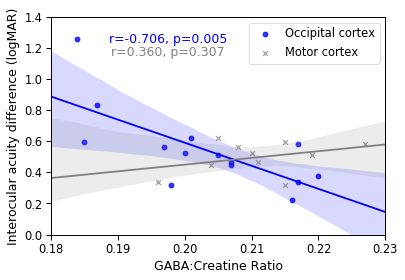

In [210]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0.18, 0.23)
ax.set_ylim(0, 1.4)

sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='blue', marker='o', ax=ax, label='Occipital cortex')
r, p = st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR'])
ax.text(.35, 0.88, f"r={r:.3f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'blue'}, horizontalalignment='center')

sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Motor cortex')
r, p = st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])
ax.text(.35, 0.82, f"r={r:.3f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

ax.legend()
ax.set_xlabel("GABA:Creatine Ratio")
ax.set_ylabel("Interocular acuity difference (logMAR)")

In [211]:
np.corrcoef(has_motor['motorGABA'], has_motor['iadLogMAR'])

array([[1.  , 0.36],
       [0.36, 1.  ]])

In [212]:
st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])

(0.3602346498548906, 0.3065303272155514)